In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

In [2]:
#importing dataset
paths = ["/share/data1/xzcaplbl/100m_1982_to_2022_8.3MW.nc"]
#ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
ds = xr.open_mfdataset(paths,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')

/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.29.0
  warnings.warn(


In [3]:
def calculate_grid_cell_area(latitude_resolution, longitude_resolution, latitudes):
    # Constants
    radius_of_earth = 6371  # Radius of the Earth in kilometers

    # Convert latitudes from degrees to radians
    latitudes_radians = [math.radians(lat) for lat in latitudes]

    # Calculate the length of 1 degree of latitude at the given latitudes
    lat_lengths = [111.32 for _ in latitudes]  # Length of 1 degree of latitude in kilometers for each latitude
    lon_lengths = [111.32 * math.cos(phi) for phi in latitudes_radians]  # Length of 1 degree of longitude in kilometers for each latitude

    # Calculate the area of the grid cell for each latitude
    areas = [lat_length * latitude_resolution * lon_length * longitude_resolution for lat_length, lon_length in zip(lat_lengths, lon_lengths)]

    # Calculate the average grid cell area
    average_area = np.mean(areas)

    return average_area

# Example usage with multiple latitudes
latitude_resolution = 0.25
longitude_resolution = 0.25
#latitudes = [50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0]  # Replace with the desired latitudes
latitudes = np.linspace(50, 70, 100)

average_grid_cell_area = calculate_grid_cell_area(latitude_resolution, longitude_resolution, latitudes)

print(f"Average area of the grid cells is approximately {average_grid_cell_area:.2f} square kilometers.")



Average area of the grid cells is approximately 385.25 square kilometers.


In [4]:
power_density = 6
area_of_grid = 385.25

grdpnt_power = area_of_grid*power_density
turbine_rating = 8.3 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 0.9 #energy lost due to wind turbines in farms


print('Total Power:',grdpnt_power,'MW per grid point')
print('Turbine Rating:',turbine_rating,'MW')
print('Number of Turbines per grid point:',int(n_turbs_grdpnt))

Total Power: 2311.5 MW per grid point
Turbine Rating: 8.3 MW
Number of Turbines per grid point: 278


In [5]:
# Assuming coords is a 3D array with shape (num_groups, num_coords, 2)
num_groups = 180
num_coords = 120
coords = np.random.rand(num_groups, num_coords, 2)  




Coords: (50.0, -12.5) Capacity factor = 63.91
Coords: (50.25, -12.5) Capacity factor = 64.03
Coords: (50.5, -12.5) Capacity factor = 64.26
Coords: (50.75, -12.5) Capacity factor = 64.42
Coords: (51.0, -12.5) Capacity factor = 64.54
Coords: (51.25, -12.5) Capacity factor = 64.79
Coords: (51.5, -12.5) Capacity factor = 64.93
Coords: (51.75, -12.5) Capacity factor = 65.09
Coords: (52.0, -12.5) Capacity factor = 65.23
Coords: (52.25, -12.5) Capacity factor = 65.35
Coords: (52.5, -12.5) Capacity factor = 65.5
Coords: (52.75, -12.5) Capacity factor = 65.58
Coords: (53.0, -12.5) Capacity factor = 65.67
Coords: (53.25, -12.5) Capacity factor = 65.73
Coords: (53.5, -12.5) Capacity factor = 65.79
Coords: (53.75, -12.5) Capacity factor = 65.88
Coords: (54.0, -12.5) Capacity factor = 65.87
Coords: (54.25, -12.5) Capacity factor = 65.94
Coords: (54.5, -12.5) Capacity factor = 65.99
Coords: (54.75, -12.5) Capacity factor = 66.04
Coords: (55.0, -12.5) Capacity factor = 66.11
Coords: (55.25, -12.5) Ca

Coords: (69.25, -12.252100840336134) Capacity factor = 62.1
Coords: (69.5, -12.252100840336134) Capacity factor = 61.66
Coords: (69.75, -12.252100840336134) Capacity factor = 61.19
Coords: (70.0, -12.252100840336134) Capacity factor = 60.69
Coords: (50.0, -12.004201680672269) Capacity factor = 63.69
Coords: (50.25, -12.004201680672269) Capacity factor = 63.9
Coords: (50.5, -12.004201680672269) Capacity factor = 64.11
Coords: (50.75, -12.004201680672269) Capacity factor = 64.17
Coords: (51.0, -12.004201680672269) Capacity factor = 64.45
Coords: (51.25, -12.004201680672269) Capacity factor = 64.54
Coords: (51.5, -12.004201680672269) Capacity factor = 64.58
Coords: (51.75, -12.004201680672269) Capacity factor = 64.77
Coords: (52.0, -12.004201680672269) Capacity factor = 64.95
Coords: (52.25, -12.004201680672269) Capacity factor = 65.1
Coords: (52.5, -12.004201680672269) Capacity factor = 65.21
Coords: (52.75, -12.004201680672269) Capacity factor = 65.26
Coords: (53.0, -12.004201680672269)

Coords: (63.25, -11.756302521008404) Capacity factor = 65.71
Coords: (63.5, -11.756302521008404) Capacity factor = 65.71
Coords: (63.75, -11.756302521008404) Capacity factor = 65.75
Coords: (64.0, -11.756302521008404) Capacity factor = 65.56
Coords: (64.25, -11.756302521008404) Capacity factor = 65.41
Coords: (64.5, -11.756302521008404) Capacity factor = 65.46
Coords: (64.75, -11.756302521008404) Capacity factor = 65.29
Coords: (65.0, -11.756302521008404) Capacity factor = 65.05
Coords: (65.25, -11.756302521008404) Capacity factor = 64.89
Coords: (65.5, -11.756302521008404) Capacity factor = 64.61
Coords: (65.75, -11.756302521008404) Capacity factor = 64.24
Coords: (66.0, -11.756302521008404) Capacity factor = 63.88
Coords: (66.25, -11.756302521008404) Capacity factor = 63.56
Coords: (66.5, -11.756302521008404) Capacity factor = 63.37
Coords: (66.75, -11.756302521008404) Capacity factor = 63.37
Coords: (67.0, -11.756302521008404) Capacity factor = 63.23
Coords: (67.25, -11.756302521008

Coords: (57.25, -11.260504201680671) Capacity factor = 65.99
Coords: (57.5, -11.260504201680671) Capacity factor = 66.03
Coords: (57.75, -11.260504201680671) Capacity factor = 66.09
Coords: (58.0, -11.260504201680671) Capacity factor = 66.09
Coords: (58.25, -11.260504201680671) Capacity factor = 66.1
Coords: (58.5, -11.260504201680671) Capacity factor = 66.1
Coords: (58.75, -11.260504201680671) Capacity factor = 66.06
Coords: (59.0, -11.260504201680671) Capacity factor = 66.06
Coords: (59.25, -11.260504201680671) Capacity factor = 66.05
Coords: (59.5, -11.260504201680671) Capacity factor = 66.05
Coords: (59.75, -11.260504201680671) Capacity factor = 66.13
Coords: (60.0, -11.260504201680671) Capacity factor = 66.1
Coords: (60.25, -11.260504201680671) Capacity factor = 66.09
Coords: (60.5, -11.260504201680671) Capacity factor = 66.11
Coords: (60.75, -11.260504201680671) Capacity factor = 66.08
Coords: (61.0, -11.260504201680671) Capacity factor = 66.13
Coords: (61.25, -11.260504201680671

Coords: (51.5, -10.764705882352942) Capacity factor = 63.41
Coords: (51.75, -10.764705882352942) Capacity factor = 63.1
Coords: (52.0, -10.764705882352942) Capacity factor = 62.03
Coords: (52.25, -10.764705882352942) Capacity factor = 62.33
Coords: (52.5, -10.764705882352942) Capacity factor = 63.52
Coords: (52.75, -10.764705882352942) Capacity factor = 64.21
Coords: (53.0, -10.764705882352942) Capacity factor = 64.42
Coords: (53.25, -10.764705882352942) Capacity factor = 64.79
Coords: (53.5, -10.764705882352942) Capacity factor = 64.56
Coords: (53.75, -10.764705882352942) Capacity factor = 64.72
Coords: (54.0, -10.764705882352942) Capacity factor = 64.81
Coords: (54.25, -10.764705882352942) Capacity factor = 64.99
Coords: (54.5, -10.764705882352942) Capacity factor = 65.29
Coords: (54.75, -10.764705882352942) Capacity factor = 65.34
Coords: (55.0, -10.764705882352942) Capacity factor = 65.52
Coords: (55.25, -10.764705882352942) Capacity factor = 65.57
Coords: (55.5, -10.76470588235294

Coords: (66.5, -10.516806722689076) Capacity factor = 64.14
Coords: (66.75, -10.516806722689076) Capacity factor = 64.09
Coords: (67.0, -10.516806722689076) Capacity factor = 64.01
Coords: (67.25, -10.516806722689076) Capacity factor = 63.83
Coords: (67.5, -10.516806722689076) Capacity factor = 63.71
Coords: (67.75, -10.516806722689076) Capacity factor = 63.57
Coords: (68.0, -10.516806722689076) Capacity factor = 63.37
Coords: (68.25, -10.516806722689076) Capacity factor = 63.21
Coords: (68.5, -10.516806722689076) Capacity factor = 63.11
Coords: (68.75, -10.516806722689076) Capacity factor = 62.97
Coords: (69.0, -10.516806722689076) Capacity factor = 62.86
Coords: (69.25, -10.516806722689076) Capacity factor = 62.48
Coords: (69.5, -10.516806722689076) Capacity factor = 61.99
Coords: (69.75, -10.516806722689076) Capacity factor = 61.51
Coords: (70.0, -10.516806722689076) Capacity factor = 60.98
Coords: (50.0, -10.26890756302521) Capacity factor = 62.75
Coords: (50.25, -10.26890756302521

Coords: (60.5, -10.021008403361344) Capacity factor = 65.88
Coords: (60.75, -10.021008403361344) Capacity factor = 65.94
Coords: (61.0, -10.021008403361344) Capacity factor = 65.98
Coords: (61.25, -10.021008403361344) Capacity factor = 65.99
Coords: (61.5, -10.021008403361344) Capacity factor = 65.95
Coords: (61.75, -10.021008403361344) Capacity factor = 65.98
Coords: (62.0, -10.021008403361344) Capacity factor = 65.89
Coords: (62.25, -10.021008403361344) Capacity factor = 65.89
Coords: (62.5, -10.021008403361344) Capacity factor = 65.8
Coords: (62.75, -10.021008403361344) Capacity factor = 65.7
Coords: (63.0, -10.021008403361344) Capacity factor = 65.68
Coords: (63.25, -10.021008403361344) Capacity factor = 65.65
Coords: (63.5, -10.021008403361344) Capacity factor = 65.57
Coords: (63.75, -10.021008403361344) Capacity factor = 65.61
Coords: (64.0, -10.021008403361344) Capacity factor = 65.57
Coords: (64.25, -10.021008403361344) Capacity factor = 65.5
Coords: (64.5, -10.021008403361344)

Coords: (54.75, -9.525210084033613) Capacity factor = 64.5
Coords: (55.0, -9.525210084033613) Capacity factor = 64.69
Coords: (55.25, -9.525210084033613) Capacity factor = 65.13
Coords: (55.5, -9.525210084033613) Capacity factor = 65.12
Coords: (55.75, -9.525210084033613) Capacity factor = 65.11
Coords: (56.0, -9.525210084033613) Capacity factor = 65.14
Coords: (56.25, -9.525210084033613) Capacity factor = 65.15
Coords: (56.5, -9.525210084033613) Capacity factor = 65.03
Coords: (56.75, -9.525210084033613) Capacity factor = 65.04
Coords: (57.0, -9.525210084033613) Capacity factor = 65.2
Coords: (57.25, -9.525210084033613) Capacity factor = 65.23
Coords: (57.5, -9.525210084033613) Capacity factor = 65.27
Coords: (57.75, -9.525210084033613) Capacity factor = 65.34
Coords: (58.0, -9.525210084033613) Capacity factor = 65.43
Coords: (58.25, -9.525210084033613) Capacity factor = 65.45
Coords: (58.5, -9.525210084033613) Capacity factor = 65.54
Coords: (58.75, -9.525210084033613) Capacity facto

Coords: (50.25, -9.029411764705882) Capacity factor = 62.12
Coords: (50.5, -9.029411764705882) Capacity factor = 62.21
Coords: (50.75, -9.029411764705882) Capacity factor = 62.27
Coords: (51.0, -9.029411764705882) Capacity factor = 62.16
Coords: (51.25, -9.029411764705882) Capacity factor = 59.62
Coords: (51.5, -9.029411764705882) Capacity factor = 52.21
Coords: (51.75, -9.029411764705882) Capacity factor = 43.28
Coords: (52.0, -9.029411764705882) Capacity factor = 36.57
Coords: (52.25, -9.029411764705882) Capacity factor = 36.12
Coords: (52.5, -9.029411764705882) Capacity factor = 36.71
Coords: (52.75, -9.029411764705882) Capacity factor = 38.49
Coords: (53.0, -9.029411764705882) Capacity factor = 41.82
Coords: (53.25, -9.029411764705882) Capacity factor = 41.33
Coords: (53.5, -9.029411764705882) Capacity factor = 39.16
Coords: (53.75, -9.029411764705882) Capacity factor = 38.52
Coords: (54.0, -9.029411764705882) Capacity factor = 40.64
Coords: (54.25, -9.029411764705882) Capacity fac

Coords: (65.0, -8.781512605042018) Capacity factor = 65.45
Coords: (65.25, -8.781512605042018) Capacity factor = 65.36
Coords: (65.5, -8.781512605042018) Capacity factor = 65.22
Coords: (65.75, -8.781512605042018) Capacity factor = 65.09
Coords: (66.0, -8.781512605042018) Capacity factor = 64.92
Coords: (66.25, -8.781512605042018) Capacity factor = 64.78
Coords: (66.5, -8.781512605042018) Capacity factor = 64.66
Coords: (66.75, -8.781512605042018) Capacity factor = 64.54
Coords: (67.0, -8.781512605042018) Capacity factor = 64.42
Coords: (67.25, -8.781512605042018) Capacity factor = 64.21
Coords: (67.5, -8.781512605042018) Capacity factor = 64.04
Coords: (67.75, -8.781512605042018) Capacity factor = 63.91
Coords: (68.0, -8.781512605042018) Capacity factor = 63.68
Coords: (68.25, -8.781512605042018) Capacity factor = 63.48
Coords: (68.5, -8.781512605042018) Capacity factor = 63.31
Coords: (68.75, -8.781512605042018) Capacity factor = 63.13
Coords: (69.0, -8.781512605042018) Capacity fact

Coords: (59.0, -8.285714285714285) Capacity factor = 65.35
Coords: (59.25, -8.285714285714285) Capacity factor = 65.35
Coords: (59.5, -8.285714285714285) Capacity factor = 65.5
Coords: (59.75, -8.285714285714285) Capacity factor = 65.47
Coords: (60.0, -8.285714285714285) Capacity factor = 65.44
Coords: (60.25, -8.285714285714285) Capacity factor = 65.45
Coords: (60.5, -8.285714285714285) Capacity factor = 65.41
Coords: (60.75, -8.285714285714285) Capacity factor = 65.48
Coords: (61.0, -8.285714285714285) Capacity factor = 65.45
Coords: (61.25, -8.285714285714285) Capacity factor = 65.39
Coords: (61.5, -8.285714285714285) Capacity factor = 65.5
Coords: (61.75, -8.285714285714285) Capacity factor = 65.38
Coords: (62.0, -8.285714285714285) Capacity factor = 65.14
Coords: (62.25, -8.285714285714285) Capacity factor = 65.24
Coords: (62.5, -8.285714285714285) Capacity factor = 65.22
Coords: (62.75, -8.285714285714285) Capacity factor = 65.44
Coords: (63.0, -8.285714285714285) Capacity factor

Coords: (56.25, -7.7899159663865545) Capacity factor = 64.21
Coords: (56.5, -7.7899159663865545) Capacity factor = 64.13
Coords: (56.75, -7.7899159663865545) Capacity factor = 63.94
Coords: (57.0, -7.7899159663865545) Capacity factor = 64.01
Coords: (57.25, -7.7899159663865545) Capacity factor = 63.94
Coords: (57.5, -7.7899159663865545) Capacity factor = 63.81
Coords: (57.75, -7.7899159663865545) Capacity factor = 63.87
Coords: (58.0, -7.7899159663865545) Capacity factor = 63.33
Coords: (58.25, -7.7899159663865545) Capacity factor = 64.33
Coords: (58.5, -7.7899159663865545) Capacity factor = 64.69
Coords: (58.75, -7.7899159663865545) Capacity factor = 65.2
Coords: (59.0, -7.7899159663865545) Capacity factor = 65.25
Coords: (59.25, -7.7899159663865545) Capacity factor = 65.38
Coords: (59.5, -7.7899159663865545) Capacity factor = 65.33
Coords: (59.75, -7.7899159663865545) Capacity factor = 65.34
Coords: (60.0, -7.7899159663865545) Capacity factor = 65.31
Coords: (60.25, -7.78991596638655

Coords: (50.25, -7.294117647058823) Capacity factor = 60.87
Coords: (50.5, -7.294117647058823) Capacity factor = 61.17
Coords: (50.75, -7.294117647058823) Capacity factor = 61.49
Coords: (51.0, -7.294117647058823) Capacity factor = 61.77
Coords: (51.25, -7.294117647058823) Capacity factor = 61.8
Coords: (51.5, -7.294117647058823) Capacity factor = 61.43
Coords: (51.75, -7.294117647058823) Capacity factor = 59.13
Coords: (52.0, -7.294117647058823) Capacity factor = 54.48
Coords: (52.25, -7.294117647058823) Capacity factor = 41.89
Coords: (52.5, -7.294117647058823) Capacity factor = 34.97
Coords: (52.75, -7.294117647058823) Capacity factor = 35.5
Coords: (53.0, -7.294117647058823) Capacity factor = 36.42
Coords: (53.25, -7.294117647058823) Capacity factor = 37.45
Coords: (53.5, -7.294117647058823) Capacity factor = 38.5
Coords: (53.75, -7.294117647058823) Capacity factor = 38.75
Coords: (54.0, -7.294117647058823) Capacity factor = 37.98
Coords: (54.25, -7.294117647058823) Capacity factor

Coords: (65.75, -7.046218487394958) Capacity factor = 64.93
Coords: (66.0, -7.046218487394958) Capacity factor = 64.77
Coords: (66.25, -7.046218487394958) Capacity factor = 64.66
Coords: (66.5, -7.046218487394958) Capacity factor = 64.51
Coords: (66.75, -7.046218487394958) Capacity factor = 64.42
Coords: (67.0, -7.046218487394958) Capacity factor = 64.24
Coords: (67.25, -7.046218487394958) Capacity factor = 64.17
Coords: (67.5, -7.046218487394958) Capacity factor = 63.99
Coords: (67.75, -7.046218487394958) Capacity factor = 63.83
Coords: (68.0, -7.046218487394958) Capacity factor = 63.66
Coords: (68.25, -7.046218487394958) Capacity factor = 63.48
Coords: (68.5, -7.046218487394958) Capacity factor = 63.27
Coords: (68.75, -7.046218487394958) Capacity factor = 63.05
Coords: (69.0, -7.046218487394958) Capacity factor = 62.86
Coords: (69.25, -7.046218487394958) Capacity factor = 62.55
Coords: (69.5, -7.046218487394958) Capacity factor = 62.24
Coords: (69.75, -7.046218487394958) Capacity fac

Coords: (59.75, -6.550420168067227) Capacity factor = 65.09
Coords: (60.0, -6.550420168067227) Capacity factor = 65.02
Coords: (60.25, -6.550420168067227) Capacity factor = 64.94
Coords: (60.5, -6.550420168067227) Capacity factor = 64.83
Coords: (60.75, -6.550420168067227) Capacity factor = 64.8
Coords: (61.0, -6.550420168067227) Capacity factor = 64.76
Coords: (61.25, -6.550420168067227) Capacity factor = 64.74
Coords: (61.5, -6.550420168067227) Capacity factor = 64.72
Coords: (61.75, -6.550420168067227) Capacity factor = 64.25
Coords: (62.0, -6.550420168067227) Capacity factor = 62.92
Coords: (62.25, -6.550420168067227) Capacity factor = 58.93
Coords: (62.5, -6.550420168067227) Capacity factor = 62.34
Coords: (62.75, -6.550420168067227) Capacity factor = 64.08
Coords: (63.0, -6.550420168067227) Capacity factor = 64.89
Coords: (63.25, -6.550420168067227) Capacity factor = 65.05
Coords: (63.5, -6.550420168067227) Capacity factor = 65.08
Coords: (63.75, -6.550420168067227) Capacity fact

Coords: (53.75, -6.054621848739496) Capacity factor = 52.33
Coords: (54.0, -6.054621848739496) Capacity factor = 51.14
Coords: (54.25, -6.054621848739496) Capacity factor = 46.0
Coords: (54.5, -6.054621848739496) Capacity factor = 42.08
Coords: (54.75, -6.054621848739496) Capacity factor = 43.49
Coords: (55.0, -6.054621848739496) Capacity factor = 48.34
Coords: (55.25, -6.054621848739496) Capacity factor = 59.62
Coords: (55.5, -6.054621848739496) Capacity factor = 61.26
Coords: (55.75, -6.054621848739496) Capacity factor = 57.31
Coords: (56.0, -6.054621848739496) Capacity factor = 59.61
Coords: (56.25, -6.054621848739496) Capacity factor = 56.8
Coords: (56.5, -6.054621848739496) Capacity factor = 52.35
Coords: (56.75, -6.054621848739496) Capacity factor = 48.56
Coords: (57.0, -6.054621848739496) Capacity factor = 47.98
Coords: (57.25, -6.054621848739496) Capacity factor = 45.26
Coords: (57.5, -6.054621848739496) Capacity factor = 47.98
Coords: (57.75, -6.054621848739496) Capacity facto

Coords: (68.75, -5.80672268907563) Capacity factor = 62.98
Coords: (69.0, -5.80672268907563) Capacity factor = 62.8
Coords: (69.25, -5.80672268907563) Capacity factor = 62.59
Coords: (69.5, -5.80672268907563) Capacity factor = 62.31
Coords: (69.75, -5.80672268907563) Capacity factor = 61.97
Coords: (70.0, -5.80672268907563) Capacity factor = 61.6
Coords: (50.0, -5.5588235294117645) Capacity factor = 56.15
Coords: (50.25, -5.5588235294117645) Capacity factor = 54.02
Coords: (50.5, -5.5588235294117645) Capacity factor = 56.59
Coords: (50.75, -5.5588235294117645) Capacity factor = 59.27
Coords: (51.0, -5.5588235294117645) Capacity factor = 60.06
Coords: (51.25, -5.5588235294117645) Capacity factor = 60.51
Coords: (51.5, -5.5588235294117645) Capacity factor = 60.24
Coords: (51.75, -5.5588235294117645) Capacity factor = 59.48
Coords: (52.0, -5.5588235294117645) Capacity factor = 59.32
Coords: (52.25, -5.5588235294117645) Capacity factor = 60.23
Coords: (52.5, -5.5588235294117645) Capacity f

Coords: (62.75, -5.310924369747899) Capacity factor = 64.91
Coords: (63.0, -5.310924369747899) Capacity factor = 65.02
Coords: (63.25, -5.310924369747899) Capacity factor = 64.94
Coords: (63.5, -5.310924369747899) Capacity factor = 64.97
Coords: (63.75, -5.310924369747899) Capacity factor = 65.04
Coords: (64.0, -5.310924369747899) Capacity factor = 65.09
Coords: (64.25, -5.310924369747899) Capacity factor = 65.14
Coords: (64.5, -5.310924369747899) Capacity factor = 65.19
Coords: (64.75, -5.310924369747899) Capacity factor = 65.14
Coords: (65.0, -5.310924369747899) Capacity factor = 65.08
Coords: (65.25, -5.310924369747899) Capacity factor = 64.91
Coords: (65.5, -5.310924369747899) Capacity factor = 64.78
Coords: (65.75, -5.310924369747899) Capacity factor = 64.67
Coords: (66.0, -5.310924369747899) Capacity factor = 64.53
Coords: (66.25, -5.310924369747899) Capacity factor = 64.41
Coords: (66.5, -5.310924369747899) Capacity factor = 64.31
Coords: (66.75, -5.310924369747899) Capacity fac

Coords: (59.5, -4.815126050420168) Capacity factor = 64.8
Coords: (59.75, -4.815126050420168) Capacity factor = 64.75
Coords: (60.0, -4.815126050420168) Capacity factor = 64.92
Coords: (60.25, -4.815126050420168) Capacity factor = 64.7
Coords: (60.5, -4.815126050420168) Capacity factor = 64.7
Coords: (60.75, -4.815126050420168) Capacity factor = 64.56
Coords: (61.0, -4.815126050420168) Capacity factor = 64.6
Coords: (61.25, -4.815126050420168) Capacity factor = 64.5
Coords: (61.5, -4.815126050420168) Capacity factor = 64.57
Coords: (61.75, -4.815126050420168) Capacity factor = 64.77
Coords: (62.0, -4.815126050420168) Capacity factor = 64.73
Coords: (62.25, -4.815126050420168) Capacity factor = 64.81
Coords: (62.5, -4.815126050420168) Capacity factor = 64.8
Coords: (62.75, -4.815126050420168) Capacity factor = 64.99
Coords: (63.0, -4.815126050420168) Capacity factor = 64.99
Coords: (63.25, -4.815126050420168) Capacity factor = 64.98
Coords: (63.5, -4.815126050420168) Capacity factor = 6

Coords: (56.0, -4.319327731092436) Capacity factor = 31.54
Coords: (56.25, -4.319327731092436) Capacity factor = 28.53
Coords: (56.5, -4.319327731092436) Capacity factor = 26.42
Coords: (56.75, -4.319327731092436) Capacity factor = 27.39
Coords: (57.0, -4.319327731092436) Capacity factor = 28.83
Coords: (57.25, -4.319327731092436) Capacity factor = 30.84
Coords: (57.5, -4.319327731092436) Capacity factor = 30.82
Coords: (57.75, -4.319327731092436) Capacity factor = 33.45
Coords: (58.0, -4.319327731092436) Capacity factor = 35.14
Coords: (58.25, -4.319327731092436) Capacity factor = 40.61
Coords: (58.5, -4.319327731092436) Capacity factor = 52.64
Coords: (58.75, -4.319327731092436) Capacity factor = 60.42
Coords: (59.0, -4.319327731092436) Capacity factor = 63.32
Coords: (59.25, -4.319327731092436) Capacity factor = 64.2
Coords: (59.5, -4.319327731092436) Capacity factor = 64.58
Coords: (59.75, -4.319327731092436) Capacity factor = 64.67
Coords: (60.0, -4.319327731092436) Capacity facto

Coords: (50.0, -3.8235294117647065) Capacity factor = 57.5
Coords: (50.25, -3.8235294117647065) Capacity factor = 52.5
Coords: (50.5, -3.8235294117647065) Capacity factor = 43.7
Coords: (50.75, -3.8235294117647065) Capacity factor = 40.07
Coords: (51.0, -3.8235294117647065) Capacity factor = 46.21
Coords: (51.25, -3.8235294117647065) Capacity factor = 52.67
Coords: (51.5, -3.8235294117647065) Capacity factor = 46.65
Coords: (51.75, -3.8235294117647065) Capacity factor = 39.07
Coords: (52.0, -3.8235294117647065) Capacity factor = 36.86
Coords: (52.25, -3.8235294117647065) Capacity factor = 37.75
Coords: (52.5, -3.8235294117647065) Capacity factor = 37.39
Coords: (52.75, -3.8235294117647065) Capacity factor = 36.34
Coords: (53.0, -3.8235294117647065) Capacity factor = 36.49
Coords: (53.25, -3.8235294117647065) Capacity factor = 38.33
Coords: (53.5, -3.8235294117647065) Capacity factor = 52.4
Coords: (53.75, -3.8235294117647065) Capacity factor = 58.69
Coords: (54.0, -3.8235294117647065) 

Coords: (65.25, -3.57563025210084) Capacity factor = 64.55
Coords: (65.5, -3.57563025210084) Capacity factor = 64.43
Coords: (65.75, -3.57563025210084) Capacity factor = 64.35
Coords: (66.0, -3.57563025210084) Capacity factor = 64.23
Coords: (66.25, -3.57563025210084) Capacity factor = 64.11
Coords: (66.5, -3.57563025210084) Capacity factor = 64.02
Coords: (66.75, -3.57563025210084) Capacity factor = 63.92
Coords: (67.0, -3.57563025210084) Capacity factor = 63.81
Coords: (67.25, -3.57563025210084) Capacity factor = 63.71
Coords: (67.5, -3.57563025210084) Capacity factor = 63.61
Coords: (67.75, -3.57563025210084) Capacity factor = 63.46
Coords: (68.0, -3.57563025210084) Capacity factor = 63.28
Coords: (68.25, -3.57563025210084) Capacity factor = 63.15
Coords: (68.5, -3.57563025210084) Capacity factor = 63.02
Coords: (68.75, -3.57563025210084) Capacity factor = 62.84
Coords: (69.0, -3.57563025210084) Capacity factor = 62.73
Coords: (69.25, -3.57563025210084) Capacity factor = 62.58
Coord

Coords: (59.0, -3.079831932773109) Capacity factor = 63.42
Coords: (59.25, -3.079831932773109) Capacity factor = 63.94
Coords: (59.5, -3.079831932773109) Capacity factor = 63.87
Coords: (59.75, -3.079831932773109) Capacity factor = 64.19
Coords: (60.0, -3.079831932773109) Capacity factor = 64.2
Coords: (60.25, -3.079831932773109) Capacity factor = 64.34
Coords: (60.5, -3.079831932773109) Capacity factor = 64.23
Coords: (60.75, -3.079831932773109) Capacity factor = 64.26
Coords: (61.0, -3.079831932773109) Capacity factor = 64.26
Coords: (61.25, -3.079831932773109) Capacity factor = 64.25
Coords: (61.5, -3.079831932773109) Capacity factor = 64.24
Coords: (61.75, -3.079831932773109) Capacity factor = 64.29
Coords: (62.0, -3.079831932773109) Capacity factor = 64.42
Coords: (62.25, -3.079831932773109) Capacity factor = 64.49
Coords: (62.5, -3.079831932773109) Capacity factor = 64.54
Coords: (62.75, -3.079831932773109) Capacity factor = 64.53
Coords: (63.0, -3.079831932773109) Capacity facto

Coords: (53.25, -2.584033613445378) Capacity factor = 37.51
Coords: (53.5, -2.584033613445378) Capacity factor = 40.61
Coords: (53.75, -2.584033613445378) Capacity factor = 40.22
Coords: (54.0, -2.584033613445378) Capacity factor = 39.32
Coords: (54.25, -2.584033613445378) Capacity factor = 38.67
Coords: (54.5, -2.584033613445378) Capacity factor = 36.29
Coords: (54.75, -2.584033613445378) Capacity factor = 36.02
Coords: (55.0, -2.584033613445378) Capacity factor = 38.16
Coords: (55.25, -2.584033613445378) Capacity factor = 40.33
Coords: (55.5, -2.584033613445378) Capacity factor = 40.75
Coords: (55.75, -2.584033613445378) Capacity factor = 44.89
Coords: (56.0, -2.584033613445378) Capacity factor = 52.92
Coords: (56.25, -2.584033613445378) Capacity factor = 52.8
Coords: (56.5, -2.584033613445378) Capacity factor = 49.68
Coords: (56.75, -2.584033613445378) Capacity factor = 43.58
Coords: (57.0, -2.584033613445378) Capacity factor = 38.44
Coords: (57.25, -2.584033613445378) Capacity fact

Coords: (68.5, -2.3361344537815114) Capacity factor = 62.92
Coords: (68.75, -2.3361344537815114) Capacity factor = 62.84
Coords: (69.0, -2.3361344537815114) Capacity factor = 62.79
Coords: (69.25, -2.3361344537815114) Capacity factor = 62.65
Coords: (69.5, -2.3361344537815114) Capacity factor = 62.45
Coords: (69.75, -2.3361344537815114) Capacity factor = 62.26
Coords: (70.0, -2.3361344537815114) Capacity factor = 62.0
Coords: (50.0, -2.0882352941176467) Capacity factor = 58.12
Coords: (50.25, -2.0882352941176467) Capacity factor = 57.7
Coords: (50.5, -2.0882352941176467) Capacity factor = 53.99
Coords: (50.75, -2.0882352941176467) Capacity factor = 43.95
Coords: (51.0, -2.0882352941176467) Capacity factor = 39.9
Coords: (51.25, -2.0882352941176467) Capacity factor = 40.03
Coords: (51.5, -2.0882352941176467) Capacity factor = 39.49
Coords: (51.75, -2.0882352941176467) Capacity factor = 39.89
Coords: (52.0, -2.0882352941176467) Capacity factor = 39.48
Coords: (52.25, -2.0882352941176467)

Coords: (62.5, -1.840336134453782) Capacity factor = 63.97
Coords: (62.75, -1.840336134453782) Capacity factor = 63.96
Coords: (63.0, -1.840336134453782) Capacity factor = 64.02
Coords: (63.25, -1.840336134453782) Capacity factor = 64.03
Coords: (63.5, -1.840336134453782) Capacity factor = 64.13
Coords: (63.75, -1.840336134453782) Capacity factor = 64.22
Coords: (64.0, -1.840336134453782) Capacity factor = 64.19
Coords: (64.25, -1.840336134453782) Capacity factor = 64.17
Coords: (64.5, -1.840336134453782) Capacity factor = 64.15
Coords: (64.75, -1.840336134453782) Capacity factor = 64.14
Coords: (65.0, -1.840336134453782) Capacity factor = 64.02
Coords: (65.25, -1.840336134453782) Capacity factor = 63.98
Coords: (65.5, -1.840336134453782) Capacity factor = 63.89
Coords: (65.75, -1.840336134453782) Capacity factor = 63.81
Coords: (66.0, -1.840336134453782) Capacity factor = 63.72
Coords: (66.25, -1.840336134453782) Capacity factor = 63.69
Coords: (66.5, -1.840336134453782) Capacity fact

Coords: (56.75, -1.3445378151260492) Capacity factor = 62.26
Coords: (57.0, -1.3445378151260492) Capacity factor = 61.56
Coords: (57.25, -1.3445378151260492) Capacity factor = 61.23
Coords: (57.5, -1.3445378151260492) Capacity factor = 60.75
Coords: (57.75, -1.3445378151260492) Capacity factor = 62.08
Coords: (58.0, -1.3445378151260492) Capacity factor = 62.43
Coords: (58.25, -1.3445378151260492) Capacity factor = 62.81
Coords: (58.5, -1.3445378151260492) Capacity factor = 62.86
Coords: (58.75, -1.3445378151260492) Capacity factor = 62.97
Coords: (59.0, -1.3445378151260492) Capacity factor = 63.04
Coords: (59.25, -1.3445378151260492) Capacity factor = 63.11
Coords: (59.5, -1.3445378151260492) Capacity factor = 63.17
Coords: (59.75, -1.3445378151260492) Capacity factor = 63.15
Coords: (60.0, -1.3445378151260492) Capacity factor = 63.27
Coords: (60.25, -1.3445378151260492) Capacity factor = 63.59
Coords: (60.5, -1.3445378151260492) Capacity factor = 63.62
Coords: (60.75, -1.3445378151260

Coords: (51.25, -0.8487394957983199) Capacity factor = 38.83
Coords: (51.5, -0.8487394957983199) Capacity factor = 37.8
Coords: (51.75, -0.8487394957983199) Capacity factor = 38.45
Coords: (52.0, -0.8487394957983199) Capacity factor = 40.34
Coords: (52.25, -0.8487394957983199) Capacity factor = 42.33
Coords: (52.5, -0.8487394957983199) Capacity factor = 43.59
Coords: (52.75, -0.8487394957983199) Capacity factor = 43.97
Coords: (53.0, -0.8487394957983199) Capacity factor = 42.86
Coords: (53.25, -0.8487394957983199) Capacity factor = 42.08
Coords: (53.5, -0.8487394957983199) Capacity factor = 41.55
Coords: (53.75, -0.8487394957983199) Capacity factor = 41.92
Coords: (54.0, -0.8487394957983199) Capacity factor = 41.98
Coords: (54.25, -0.8487394957983199) Capacity factor = 47.02
Coords: (54.5, -0.8487394957983199) Capacity factor = 52.43
Coords: (54.75, -0.8487394957983199) Capacity factor = 55.11
Coords: (55.0, -0.8487394957983199) Capacity factor = 57.37
Coords: (55.25, -0.84873949579831

Coords: (66.25, -0.6008403361344534) Capacity factor = 63.32
Coords: (66.5, -0.6008403361344534) Capacity factor = 63.26
Coords: (66.75, -0.6008403361344534) Capacity factor = 63.23
Coords: (67.0, -0.6008403361344534) Capacity factor = 63.14
Coords: (67.25, -0.6008403361344534) Capacity factor = 63.01
Coords: (67.5, -0.6008403361344534) Capacity factor = 62.87
Coords: (67.75, -0.6008403361344534) Capacity factor = 62.78
Coords: (68.0, -0.6008403361344534) Capacity factor = 62.74
Coords: (68.25, -0.6008403361344534) Capacity factor = 62.71
Coords: (68.5, -0.6008403361344534) Capacity factor = 62.68
Coords: (68.75, -0.6008403361344534) Capacity factor = 62.59
Coords: (69.0, -0.6008403361344534) Capacity factor = 62.48
Coords: (69.25, -0.6008403361344534) Capacity factor = 62.31
Coords: (69.5, -0.6008403361344534) Capacity factor = 62.15
Coords: (69.75, -0.6008403361344534) Capacity factor = 61.97
Coords: (70.0, -0.6008403361344534) Capacity factor = 61.8
Coords: (50.0, -0.352941176470587

Coords: (60.25, -0.10504201680672232) Capacity factor = 62.22
Coords: (60.5, -0.10504201680672232) Capacity factor = 62.13
Coords: (60.75, -0.10504201680672232) Capacity factor = 62.04
Coords: (61.0, -0.10504201680672232) Capacity factor = 62.06
Coords: (61.25, -0.10504201680672232) Capacity factor = 62.12
Coords: (61.5, -0.10504201680672232) Capacity factor = 62.18
Coords: (61.75, -0.10504201680672232) Capacity factor = 62.3
Coords: (62.0, -0.10504201680672232) Capacity factor = 62.48
Coords: (62.25, -0.10504201680672232) Capacity factor = 62.66
Coords: (62.5, -0.10504201680672232) Capacity factor = 62.82
Coords: (62.75, -0.10504201680672232) Capacity factor = 63.0
Coords: (63.0, -0.10504201680672232) Capacity factor = 63.12
Coords: (63.25, -0.10504201680672232) Capacity factor = 63.22
Coords: (63.5, -0.10504201680672232) Capacity factor = 63.26
Coords: (63.75, -0.10504201680672232) Capacity factor = 63.26
Coords: (64.0, -0.10504201680672232) Capacity factor = 63.25
Coords: (64.25, -0

Coords: (54.0, 0.3907563025210088) Capacity factor = 58.99
Coords: (54.25, 0.3907563025210088) Capacity factor = 59.38
Coords: (54.5, 0.3907563025210088) Capacity factor = 59.84
Coords: (54.75, 0.3907563025210088) Capacity factor = 60.42
Coords: (55.0, 0.3907563025210088) Capacity factor = 60.85
Coords: (55.25, 0.3907563025210088) Capacity factor = 60.98
Coords: (55.5, 0.3907563025210088) Capacity factor = 61.3
Coords: (55.75, 0.3907563025210088) Capacity factor = 61.64
Coords: (56.0, 0.3907563025210088) Capacity factor = 61.76
Coords: (56.25, 0.3907563025210088) Capacity factor = 61.83
Coords: (56.5, 0.3907563025210088) Capacity factor = 61.89
Coords: (56.75, 0.3907563025210088) Capacity factor = 61.91
Coords: (57.0, 0.3907563025210088) Capacity factor = 61.84
Coords: (57.25, 0.3907563025210088) Capacity factor = 61.73
Coords: (57.5, 0.3907563025210088) Capacity factor = 61.71
Coords: (57.75, 0.3907563025210088) Capacity factor = 61.82
Coords: (58.0, 0.3907563025210088) Capacity facto

Coords: (69.0, 0.6386554621848752) Capacity factor = 62.24
Coords: (69.25, 0.6386554621848752) Capacity factor = 62.04
Coords: (69.5, 0.6386554621848752) Capacity factor = 61.92
Coords: (69.75, 0.6386554621848752) Capacity factor = 61.79
Coords: (70.0, 0.6386554621848752) Capacity factor = 61.65
Coords: (50.0, 0.8865546218487399) Capacity factor = 46.33
Coords: (50.25, 0.8865546218487399) Capacity factor = 52.44
Coords: (50.5, 0.8865546218487399) Capacity factor = 54.64
Coords: (50.75, 0.8865546218487399) Capacity factor = 54.57
Coords: (51.0, 0.8865546218487399) Capacity factor = 47.98
Coords: (51.25, 0.8865546218487399) Capacity factor = 43.25
Coords: (51.5, 0.8865546218487399) Capacity factor = 47.83
Coords: (51.75, 0.8865546218487399) Capacity factor = 48.11
Coords: (52.0, 0.8865546218487399) Capacity factor = 44.82
Coords: (52.25, 0.8865546218487399) Capacity factor = 40.77
Coords: (52.5, 0.8865546218487399) Capacity factor = 40.85
Coords: (52.75, 0.8865546218487399) Capacity fact

Coords: (63.0, 1.1344537815126046) Capacity factor = 62.29
Coords: (63.25, 1.1344537815126046) Capacity factor = 62.44
Coords: (63.5, 1.1344537815126046) Capacity factor = 62.54
Coords: (63.75, 1.1344537815126046) Capacity factor = 62.57
Coords: (64.0, 1.1344537815126046) Capacity factor = 62.48
Coords: (64.25, 1.1344537815126046) Capacity factor = 62.43
Coords: (64.5, 1.1344537815126046) Capacity factor = 62.52
Coords: (64.75, 1.1344537815126046) Capacity factor = 62.55
Coords: (65.0, 1.1344537815126046) Capacity factor = 62.56
Coords: (65.25, 1.1344537815126046) Capacity factor = 62.62
Coords: (65.5, 1.1344537815126046) Capacity factor = 62.7
Coords: (65.75, 1.1344537815126046) Capacity factor = 62.72
Coords: (66.0, 1.1344537815126046) Capacity factor = 62.72
Coords: (66.25, 1.1344537815126046) Capacity factor = 62.75
Coords: (66.5, 1.1344537815126046) Capacity factor = 62.74
Coords: (66.75, 1.1344537815126046) Capacity factor = 62.67
Coords: (67.0, 1.1344537815126046) Capacity facto

Coords: (60.25, 1.6302521008403374) Capacity factor = 60.24
Coords: (60.5, 1.6302521008403374) Capacity factor = 60.11
Coords: (60.75, 1.6302521008403374) Capacity factor = 60.03
Coords: (61.0, 1.6302521008403374) Capacity factor = 59.94
Coords: (61.25, 1.6302521008403374) Capacity factor = 60.01
Coords: (61.5, 1.6302521008403374) Capacity factor = 60.17
Coords: (61.75, 1.6302521008403374) Capacity factor = 60.47
Coords: (62.0, 1.6302521008403374) Capacity factor = 60.81
Coords: (62.25, 1.6302521008403374) Capacity factor = 61.15
Coords: (62.5, 1.6302521008403374) Capacity factor = 61.48
Coords: (62.75, 1.6302521008403374) Capacity factor = 61.83
Coords: (63.0, 1.6302521008403374) Capacity factor = 62.06
Coords: (63.25, 1.6302521008403374) Capacity factor = 62.14
Coords: (63.5, 1.6302521008403374) Capacity factor = 62.16
Coords: (63.75, 1.6302521008403374) Capacity factor = 62.15
Coords: (64.0, 1.6302521008403374) Capacity factor = 62.15
Coords: (64.25, 1.6302521008403374) Capacity fac

Coords: (54.75, 2.126050420168067) Capacity factor = 60.63
Coords: (55.0, 2.126050420168067) Capacity factor = 60.85
Coords: (55.25, 2.126050420168067) Capacity factor = 61.15
Coords: (55.5, 2.126050420168067) Capacity factor = 61.11
Coords: (55.75, 2.126050420168067) Capacity factor = 61.16
Coords: (56.0, 2.126050420168067) Capacity factor = 61.25
Coords: (56.25, 2.126050420168067) Capacity factor = 61.21
Coords: (56.5, 2.126050420168067) Capacity factor = 61.28
Coords: (56.75, 2.126050420168067) Capacity factor = 61.32
Coords: (57.0, 2.126050420168067) Capacity factor = 61.32
Coords: (57.25, 2.126050420168067) Capacity factor = 61.35
Coords: (57.5, 2.126050420168067) Capacity factor = 61.44
Coords: (57.75, 2.126050420168067) Capacity factor = 61.6
Coords: (58.0, 2.126050420168067) Capacity factor = 61.57
Coords: (58.25, 2.126050420168067) Capacity factor = 61.48
Coords: (58.5, 2.126050420168067) Capacity factor = 61.32
Coords: (58.75, 2.126050420168067) Capacity factor = 61.13
Coords

Coords: (50.0, 2.6218487394957997) Capacity factor = 34.72
Coords: (50.25, 2.6218487394957997) Capacity factor = 36.89
Coords: (50.5, 2.6218487394957997) Capacity factor = 37.16
Coords: (50.75, 2.6218487394957997) Capacity factor = 34.98
Coords: (51.0, 2.6218487394957997) Capacity factor = 39.06
Coords: (51.25, 2.6218487394957997) Capacity factor = 52.04
Coords: (51.5, 2.6218487394957997) Capacity factor = 56.63
Coords: (51.75, 2.6218487394957997) Capacity factor = 57.8
Coords: (52.0, 2.6218487394957997) Capacity factor = 58.1
Coords: (52.25, 2.6218487394957997) Capacity factor = 58.21
Coords: (52.5, 2.6218487394957997) Capacity factor = 58.17
Coords: (52.75, 2.6218487394957997) Capacity factor = 58.38
Coords: (53.0, 2.6218487394957997) Capacity factor = 58.71
Coords: (53.25, 2.6218487394957997) Capacity factor = 59.07
Coords: (53.5, 2.6218487394957997) Capacity factor = 59.37
Coords: (53.75, 2.6218487394957997) Capacity factor = 59.73
Coords: (54.0, 2.6218487394957997) Capacity factor

Coords: (65.0, 2.8697478991596643) Capacity factor = 61.35
Coords: (65.25, 2.8697478991596643) Capacity factor = 61.44
Coords: (65.5, 2.8697478991596643) Capacity factor = 61.57
Coords: (65.75, 2.8697478991596643) Capacity factor = 61.72
Coords: (66.0, 2.8697478991596643) Capacity factor = 61.78
Coords: (66.25, 2.8697478991596643) Capacity factor = 61.75
Coords: (66.5, 2.8697478991596643) Capacity factor = 61.76
Coords: (66.75, 2.8697478991596643) Capacity factor = 61.81
Coords: (67.0, 2.8697478991596643) Capacity factor = 61.72
Coords: (67.25, 2.8697478991596643) Capacity factor = 61.71
Coords: (67.5, 2.8697478991596643) Capacity factor = 61.74
Coords: (67.75, 2.8697478991596643) Capacity factor = 61.74
Coords: (68.0, 2.8697478991596643) Capacity factor = 61.73
Coords: (68.25, 2.8697478991596643) Capacity factor = 61.72
Coords: (68.5, 2.8697478991596643) Capacity factor = 61.67
Coords: (68.75, 2.8697478991596643) Capacity factor = 61.63
Coords: (69.0, 2.8697478991596643) Capacity fact

Coords: (62.0, 3.3655462184873954) Capacity factor = 60.0
Coords: (62.25, 3.3655462184873954) Capacity factor = 60.24
Coords: (62.5, 3.3655462184873954) Capacity factor = 60.37
Coords: (62.75, 3.3655462184873954) Capacity factor = 60.51
Coords: (63.0, 3.3655462184873954) Capacity factor = 60.65
Coords: (63.25, 3.3655462184873954) Capacity factor = 60.6
Coords: (63.5, 3.3655462184873954) Capacity factor = 60.65
Coords: (63.75, 3.3655462184873954) Capacity factor = 60.74
Coords: (64.0, 3.3655462184873954) Capacity factor = 60.75
Coords: (64.25, 3.3655462184873954) Capacity factor = 60.7
Coords: (64.5, 3.3655462184873954) Capacity factor = 60.79
Coords: (64.75, 3.3655462184873954) Capacity factor = 60.8
Coords: (65.0, 3.3655462184873954) Capacity factor = 60.88
Coords: (65.25, 3.3655462184873954) Capacity factor = 61.02
Coords: (65.5, 3.3655462184873954) Capacity factor = 61.13
Coords: (65.75, 3.3655462184873954) Capacity factor = 61.24
Coords: (66.0, 3.3655462184873954) Capacity factor =

Coords: (59.25, 3.8613445378151283) Capacity factor = 59.59
Coords: (59.5, 3.8613445378151283) Capacity factor = 58.85
Coords: (59.75, 3.8613445378151283) Capacity factor = 58.25
Coords: (60.0, 3.8613445378151283) Capacity factor = 57.6
Coords: (60.25, 3.8613445378151283) Capacity factor = 57.01
Coords: (60.5, 3.8613445378151283) Capacity factor = 56.75
Coords: (60.75, 3.8613445378151283) Capacity factor = 56.73
Coords: (61.0, 3.8613445378151283) Capacity factor = 57.05
Coords: (61.25, 3.8613445378151283) Capacity factor = 57.69
Coords: (61.5, 3.8613445378151283) Capacity factor = 58.41
Coords: (61.75, 3.8613445378151283) Capacity factor = 58.77
Coords: (62.0, 3.8613445378151283) Capacity factor = 59.36
Coords: (62.25, 3.8613445378151283) Capacity factor = 59.78
Coords: (62.5, 3.8613445378151283) Capacity factor = 59.9
Coords: (62.75, 3.8613445378151283) Capacity factor = 59.87
Coords: (63.0, 3.8613445378151283) Capacity factor = 59.98
Coords: (63.25, 3.8613445378151283) Capacity facto

Coords: (56.5, 4.357142857142858) Capacity factor = 62.74
Coords: (56.75, 4.357142857142858) Capacity factor = 63.04
Coords: (57.0, 4.357142857142858) Capacity factor = 63.2
Coords: (57.25, 4.357142857142858) Capacity factor = 63.41
Coords: (57.5, 4.357142857142858) Capacity factor = 63.5
Coords: (57.75, 4.357142857142858) Capacity factor = 63.38
Coords: (58.0, 4.357142857142858) Capacity factor = 63.23
Coords: (58.25, 4.357142857142858) Capacity factor = 62.56
Coords: (58.5, 4.357142857142858) Capacity factor = 61.82
Coords: (58.75, 4.357142857142858) Capacity factor = 60.64
Coords: (59.0, 4.357142857142858) Capacity factor = 59.75
Coords: (59.25, 4.357142857142858) Capacity factor = 58.91
Coords: (59.5, 4.357142857142858) Capacity factor = 57.98
Coords: (59.75, 4.357142857142858) Capacity factor = 56.67
Coords: (60.0, 4.357142857142858) Capacity factor = 55.71
Coords: (60.25, 4.357142857142858) Capacity factor = 55.47
Coords: (60.5, 4.357142857142858) Capacity factor = 54.86
Coords: 

Coords: (53.75, 4.852941176470587) Capacity factor = 60.06
Coords: (54.0, 4.852941176470587) Capacity factor = 60.5
Coords: (54.25, 4.852941176470587) Capacity factor = 60.91
Coords: (54.5, 4.852941176470587) Capacity factor = 61.22
Coords: (54.75, 4.852941176470587) Capacity factor = 61.49
Coords: (55.0, 4.852941176470587) Capacity factor = 61.83
Coords: (55.25, 4.852941176470587) Capacity factor = 62.16
Coords: (55.5, 4.852941176470587) Capacity factor = 62.34
Coords: (55.75, 4.852941176470587) Capacity factor = 62.63
Coords: (56.0, 4.852941176470587) Capacity factor = 62.87
Coords: (56.25, 4.852941176470587) Capacity factor = 63.15
Coords: (56.5, 4.852941176470587) Capacity factor = 63.34
Coords: (56.75, 4.852941176470587) Capacity factor = 63.45
Coords: (57.0, 4.852941176470587) Capacity factor = 63.8
Coords: (57.25, 4.852941176470587) Capacity factor = 64.05
Coords: (57.5, 4.852941176470587) Capacity factor = 64.11
Coords: (57.75, 4.852941176470587) Capacity factor = 64.18
Coords:

Coords: (50.75, 5.34873949579832) Capacity factor = 34.64
Coords: (51.0, 5.34873949579832) Capacity factor = 31.79
Coords: (51.25, 5.34873949579832) Capacity factor = 31.78
Coords: (51.5, 5.34873949579832) Capacity factor = 32.92
Coords: (51.75, 5.34873949579832) Capacity factor = 34.82
Coords: (52.0, 5.34873949579832) Capacity factor = 36.11
Coords: (52.25, 5.34873949579832) Capacity factor = 38.13
Coords: (52.5, 5.34873949579832) Capacity factor = 42.54
Coords: (52.75, 5.34873949579832) Capacity factor = 49.36
Coords: (53.0, 5.34873949579832) Capacity factor = 55.3
Coords: (53.25, 5.34873949579832) Capacity factor = 57.12
Coords: (53.5, 5.34873949579832) Capacity factor = 59.38
Coords: (53.75, 5.34873949579832) Capacity factor = 60.09
Coords: (54.0, 5.34873949579832) Capacity factor = 60.63
Coords: (54.25, 5.34873949579832) Capacity factor = 61.15
Coords: (54.5, 5.34873949579832) Capacity factor = 61.49
Coords: (54.75, 5.34873949579832) Capacity factor = 61.78
Coords: (55.0, 5.348739

Coords: (66.0, 5.596638655462186) Capacity factor = 59.41
Coords: (66.25, 5.596638655462186) Capacity factor = 59.65
Coords: (66.5, 5.596638655462186) Capacity factor = 59.89
Coords: (66.75, 5.596638655462186) Capacity factor = 60.09
Coords: (67.0, 5.596638655462186) Capacity factor = 60.17
Coords: (67.25, 5.596638655462186) Capacity factor = 60.21
Coords: (67.5, 5.596638655462186) Capacity factor = 60.25
Coords: (67.75, 5.596638655462186) Capacity factor = 60.29
Coords: (68.0, 5.596638655462186) Capacity factor = 60.4
Coords: (68.25, 5.596638655462186) Capacity factor = 60.52
Coords: (68.5, 5.596638655462186) Capacity factor = 60.59
Coords: (68.75, 5.596638655462186) Capacity factor = 60.64
Coords: (69.0, 5.596638655462186) Capacity factor = 60.68
Coords: (69.25, 5.596638655462186) Capacity factor = 60.67
Coords: (69.5, 5.596638655462186) Capacity factor = 60.67
Coords: (69.75, 5.596638655462186) Capacity factor = 60.71
Coords: (70.0, 5.596638655462186) Capacity factor = 60.77
Coords:

Coords: (60.75, 6.092436974789916) Capacity factor = 7.4
Coords: (61.0, 6.092436974789916) Capacity factor = 6.43
Coords: (61.25, 6.092436974789916) Capacity factor = 5.03
Coords: (61.5, 6.092436974789916) Capacity factor = 4.89
Coords: (61.75, 6.092436974789916) Capacity factor = 6.01
Coords: (62.0, 6.092436974789916) Capacity factor = 6.28
Coords: (62.25, 6.092436974789916) Capacity factor = 20.87
Coords: (62.5, 6.092436974789916) Capacity factor = 39.98
Coords: (62.75, 6.092436974789916) Capacity factor = 49.93
Coords: (63.0, 6.092436974789916) Capacity factor = 52.62
Coords: (63.25, 6.092436974789916) Capacity factor = 54.14
Coords: (63.5, 6.092436974789916) Capacity factor = 55.05
Coords: (63.75, 6.092436974789916) Capacity factor = 55.75
Coords: (64.0, 6.092436974789916) Capacity factor = 56.15
Coords: (64.25, 6.092436974789916) Capacity factor = 56.76
Coords: (64.5, 6.092436974789916) Capacity factor = 57.08
Coords: (64.75, 6.092436974789916) Capacity factor = 57.46
Coords: (65.

Coords: (56.0, 6.5882352941176485) Capacity factor = 63.38
Coords: (56.25, 6.5882352941176485) Capacity factor = 63.83
Coords: (56.5, 6.5882352941176485) Capacity factor = 64.33
Coords: (56.75, 6.5882352941176485) Capacity factor = 64.71
Coords: (57.0, 6.5882352941176485) Capacity factor = 65.19
Coords: (57.25, 6.5882352941176485) Capacity factor = 65.43
Coords: (57.5, 6.5882352941176485) Capacity factor = 65.3
Coords: (57.75, 6.5882352941176485) Capacity factor = 65.27
Coords: (58.0, 6.5882352941176485) Capacity factor = 61.13
Coords: (58.25, 6.5882352941176485) Capacity factor = 45.64
Coords: (58.5, 6.5882352941176485) Capacity factor = 33.64
Coords: (58.75, 6.5882352941176485) Capacity factor = 30.37
Coords: (59.0, 6.5882352941176485) Capacity factor = 26.02
Coords: (59.25, 6.5882352941176485) Capacity factor = 17.76
Coords: (59.5, 6.5882352941176485) Capacity factor = 10.61
Coords: (59.75, 6.5882352941176485) Capacity factor = 6.24
Coords: (60.0, 6.5882352941176485) Capacity factor

Coords: (52.75, 7.084033613445378) Capacity factor = 37.43
Coords: (53.0, 7.084033613445378) Capacity factor = 38.71
Coords: (53.25, 7.084033613445378) Capacity factor = 40.84
Coords: (53.5, 7.084033613445378) Capacity factor = 49.03
Coords: (53.75, 7.084033613445378) Capacity factor = 56.6
Coords: (54.0, 7.084033613445378) Capacity factor = 60.57
Coords: (54.25, 7.084033613445378) Capacity factor = 61.25
Coords: (54.5, 7.084033613445378) Capacity factor = 61.71
Coords: (54.75, 7.084033613445378) Capacity factor = 62.04
Coords: (55.0, 7.084033613445378) Capacity factor = 62.34
Coords: (55.25, 7.084033613445378) Capacity factor = 62.57
Coords: (55.5, 7.084033613445378) Capacity factor = 62.47
Coords: (55.75, 7.084033613445378) Capacity factor = 62.69
Coords: (56.0, 7.084033613445378) Capacity factor = 63.04
Coords: (56.25, 7.084033613445378) Capacity factor = 63.49
Coords: (56.5, 7.084033613445378) Capacity factor = 63.78
Coords: (56.75, 7.084033613445378) Capacity factor = 64.24
Coords

Coords: (68.0, 7.331932773109244) Capacity factor = 59.72
Coords: (68.25, 7.331932773109244) Capacity factor = 59.8
Coords: (68.5, 7.331932773109244) Capacity factor = 59.88
Coords: (68.75, 7.331932773109244) Capacity factor = 59.9
Coords: (69.0, 7.331932773109244) Capacity factor = 60.05
Coords: (69.25, 7.331932773109244) Capacity factor = 60.11
Coords: (69.5, 7.331932773109244) Capacity factor = 60.16
Coords: (69.75, 7.331932773109244) Capacity factor = 60.21
Coords: (70.0, 7.331932773109244) Capacity factor = 60.3
Coords: (50.0, 7.579831932773111) Capacity factor = 24.09
Coords: (50.25, 7.579831932773111) Capacity factor = 23.69
Coords: (50.5, 7.579831932773111) Capacity factor = 23.27
Coords: (50.75, 7.579831932773111) Capacity factor = 26.34
Coords: (51.0, 7.579831932773111) Capacity factor = 32.24
Coords: (51.25, 7.579831932773111) Capacity factor = 34.7
Coords: (51.5, 7.579831932773111) Capacity factor = 33.4
Coords: (51.75, 7.579831932773111) Capacity factor = 32.06
Coords: (52

Coords: (65.25, 7.827731092436977) Capacity factor = 56.6
Coords: (65.5, 7.827731092436977) Capacity factor = 57.07
Coords: (65.75, 7.827731092436977) Capacity factor = 57.44
Coords: (66.0, 7.827731092436977) Capacity factor = 57.85
Coords: (66.25, 7.827731092436977) Capacity factor = 58.27
Coords: (66.5, 7.827731092436977) Capacity factor = 58.61
Coords: (66.75, 7.827731092436977) Capacity factor = 58.97
Coords: (67.0, 7.827731092436977) Capacity factor = 59.07
Coords: (67.25, 7.827731092436977) Capacity factor = 59.22
Coords: (67.5, 7.827731092436977) Capacity factor = 59.35
Coords: (67.75, 7.827731092436977) Capacity factor = 59.42
Coords: (68.0, 7.827731092436977) Capacity factor = 59.45
Coords: (68.25, 7.827731092436977) Capacity factor = 59.54
Coords: (68.5, 7.827731092436977) Capacity factor = 59.65
Coords: (68.75, 7.827731092436977) Capacity factor = 59.69
Coords: (69.0, 7.827731092436977) Capacity factor = 59.82
Coords: (69.25, 7.827731092436977) Capacity factor = 59.9
Coords:

Coords: (62.5, 8.323529411764707) Capacity factor = 7.13
Coords: (62.75, 8.323529411764707) Capacity factor = 5.33
Coords: (63.0, 8.323529411764707) Capacity factor = 11.39
Coords: (63.25, 8.323529411764707) Capacity factor = 28.76
Coords: (63.5, 8.323529411764707) Capacity factor = 43.04
Coords: (63.75, 8.323529411764707) Capacity factor = 48.61
Coords: (64.0, 8.323529411764707) Capacity factor = 51.98
Coords: (64.25, 8.323529411764707) Capacity factor = 53.85
Coords: (64.5, 8.323529411764707) Capacity factor = 54.79
Coords: (64.75, 8.323529411764707) Capacity factor = 55.33
Coords: (65.0, 8.323529411764707) Capacity factor = 55.89
Coords: (65.25, 8.323529411764707) Capacity factor = 56.51
Coords: (65.5, 8.323529411764707) Capacity factor = 56.98
Coords: (65.75, 8.323529411764707) Capacity factor = 57.29
Coords: (66.0, 8.323529411764707) Capacity factor = 57.66
Coords: (66.25, 8.323529411764707) Capacity factor = 58.02
Coords: (66.5, 8.323529411764707) Capacity factor = 58.3
Coords: (

Coords: (57.75, 8.819327731092436) Capacity factor = 61.33
Coords: (58.0, 8.819327731092436) Capacity factor = 58.27
Coords: (58.25, 8.819327731092436) Capacity factor = 46.8
Coords: (58.5, 8.819327731092436) Capacity factor = 33.71
Coords: (58.75, 8.819327731092436) Capacity factor = 26.78
Coords: (59.0, 8.819327731092436) Capacity factor = 17.35
Coords: (59.25, 8.819327731092436) Capacity factor = 10.14
Coords: (59.5, 8.819327731092436) Capacity factor = 7.69
Coords: (59.75, 8.819327731092436) Capacity factor = 9.63
Coords: (60.0, 8.819327731092436) Capacity factor = 14.39
Coords: (60.25, 8.819327731092436) Capacity factor = 14.98
Coords: (60.5, 8.819327731092436) Capacity factor = 10.84
Coords: (60.75, 8.819327731092436) Capacity factor = 7.88
Coords: (61.0, 8.819327731092436) Capacity factor = 6.7
Coords: (61.25, 8.819327731092436) Capacity factor = 8.63
Coords: (61.5, 8.819327731092436) Capacity factor = 8.35
Coords: (61.75, 8.819327731092436) Capacity factor = 4.9
Coords: (62.0, 

Coords: (53.0, 9.315126050420169) Capacity factor = 31.92
Coords: (53.25, 9.315126050420169) Capacity factor = 32.38
Coords: (53.5, 9.315126050420169) Capacity factor = 33.14
Coords: (53.75, 9.315126050420169) Capacity factor = 35.16
Coords: (54.0, 9.315126050420169) Capacity factor = 38.22
Coords: (54.25, 9.315126050420169) Capacity factor = 40.0
Coords: (54.5, 9.315126050420169) Capacity factor = 41.1
Coords: (54.75, 9.315126050420169) Capacity factor = 40.03
Coords: (55.0, 9.315126050420169) Capacity factor = 40.21
Coords: (55.25, 9.315126050420169) Capacity factor = 40.93
Coords: (55.5, 9.315126050420169) Capacity factor = 39.96
Coords: (55.75, 9.315126050420169) Capacity factor = 42.46
Coords: (56.0, 9.315126050420169) Capacity factor = 43.95
Coords: (56.25, 9.315126050420169) Capacity factor = 42.23
Coords: (56.5, 9.315126050420169) Capacity factor = 41.97
Coords: (56.75, 9.315126050420169) Capacity factor = 45.84
Coords: (57.0, 9.315126050420169) Capacity factor = 48.8
Coords: (

Coords: (68.25, 9.563025210084035) Capacity factor = 58.29
Coords: (68.5, 9.563025210084035) Capacity factor = 58.43
Coords: (68.75, 9.563025210084035) Capacity factor = 58.61
Coords: (69.0, 9.563025210084035) Capacity factor = 58.77
Coords: (69.25, 9.563025210084035) Capacity factor = 58.91
Coords: (69.5, 9.563025210084035) Capacity factor = 59.01
Coords: (69.75, 9.563025210084035) Capacity factor = 59.07
Coords: (70.0, 9.563025210084035) Capacity factor = 59.17
Coords: (50.0, 9.810924369747902) Capacity factor = 21.4
Coords: (50.25, 9.810924369747902) Capacity factor = 22.64
Coords: (50.5, 9.810924369747902) Capacity factor = 23.89
Coords: (50.75, 9.810924369747902) Capacity factor = 25.23
Coords: (51.0, 9.810924369747902) Capacity factor = 25.45
Coords: (51.25, 9.810924369747902) Capacity factor = 24.86
Coords: (51.5, 9.810924369747902) Capacity factor = 24.9
Coords: (51.75, 9.810924369747902) Capacity factor = 26.23
Coords: (52.0, 9.810924369747902) Capacity factor = 28.44
Coords: 

Coords: (62.75, 10.058823529411764) Capacity factor = 20.55
Coords: (63.0, 10.058823529411764) Capacity factor = 19.54
Coords: (63.25, 10.058823529411764) Capacity factor = 16.13
Coords: (63.5, 10.058823529411764) Capacity factor = 25.98
Coords: (63.75, 10.058823529411764) Capacity factor = 33.79
Coords: (64.0, 10.058823529411764) Capacity factor = 41.92
Coords: (64.25, 10.058823529411764) Capacity factor = 50.05
Coords: (64.5, 10.058823529411764) Capacity factor = 54.51
Coords: (64.75, 10.058823529411764) Capacity factor = 55.4
Coords: (65.0, 10.058823529411764) Capacity factor = 55.96
Coords: (65.25, 10.058823529411764) Capacity factor = 56.59
Coords: (65.5, 10.058823529411764) Capacity factor = 56.95
Coords: (65.75, 10.058823529411764) Capacity factor = 57.09
Coords: (66.0, 10.058823529411764) Capacity factor = 57.13
Coords: (66.25, 10.058823529411764) Capacity factor = 57.14
Coords: (66.5, 10.058823529411764) Capacity factor = 57.32
Coords: (66.75, 10.058823529411764) Capacity fact

Coords: (57.0, 10.554621848739497) Capacity factor = 55.67
Coords: (57.25, 10.554621848739497) Capacity factor = 54.87
Coords: (57.5, 10.554621848739497) Capacity factor = 55.17
Coords: (57.75, 10.554621848739497) Capacity factor = 57.55
Coords: (58.0, 10.554621848739497) Capacity factor = 58.18
Coords: (58.25, 10.554621848739497) Capacity factor = 57.1
Coords: (58.5, 10.554621848739497) Capacity factor = 55.85
Coords: (58.75, 10.554621848739497) Capacity factor = 53.13
Coords: (59.0, 10.554621848739497) Capacity factor = 46.2
Coords: (59.25, 10.554621848739497) Capacity factor = 33.86
Coords: (59.5, 10.554621848739497) Capacity factor = 21.43
Coords: (59.75, 10.554621848739497) Capacity factor = 14.8
Coords: (60.0, 10.554621848739497) Capacity factor = 13.35
Coords: (60.25, 10.554621848739497) Capacity factor = 13.09
Coords: (60.5, 10.554621848739497) Capacity factor = 11.5
Coords: (60.75, 10.554621848739497) Capacity factor = 9.64
Coords: (61.0, 10.554621848739497) Capacity factor = 

Coords: (51.75, 11.050420168067227) Capacity factor = 27.91
Coords: (52.0, 11.050420168067227) Capacity factor = 28.08
Coords: (52.25, 11.050420168067227) Capacity factor = 29.01
Coords: (52.5, 11.050420168067227) Capacity factor = 30.69
Coords: (52.75, 11.050420168067227) Capacity factor = 30.35
Coords: (53.0, 11.050420168067227) Capacity factor = 30.62
Coords: (53.25, 11.050420168067227) Capacity factor = 30.92
Coords: (53.5, 11.050420168067227) Capacity factor = 33.36
Coords: (53.75, 11.050420168067227) Capacity factor = 37.26
Coords: (54.0, 11.050420168067227) Capacity factor = 42.66
Coords: (54.25, 11.050420168067227) Capacity factor = 50.46
Coords: (54.5, 11.050420168067227) Capacity factor = 54.51
Coords: (54.75, 11.050420168067227) Capacity factor = 57.13
Coords: (55.0, 11.050420168067227) Capacity factor = 56.77
Coords: (55.25, 11.050420168067227) Capacity factor = 51.73
Coords: (55.5, 11.050420168067227) Capacity factor = 52.21
Coords: (55.75, 11.050420168067227) Capacity fac

Coords: (66.75, 11.298319327731093) Capacity factor = 56.22
Coords: (67.0, 11.298319327731093) Capacity factor = 55.89
Coords: (67.25, 11.298319327731093) Capacity factor = 55.54
Coords: (67.5, 11.298319327731093) Capacity factor = 55.62
Coords: (67.75, 11.298319327731093) Capacity factor = 55.81
Coords: (68.0, 11.298319327731093) Capacity factor = 56.07
Coords: (68.25, 11.298319327731093) Capacity factor = 56.17
Coords: (68.5, 11.298319327731093) Capacity factor = 56.82
Coords: (68.75, 11.298319327731093) Capacity factor = 57.1
Coords: (69.0, 11.298319327731093) Capacity factor = 57.52
Coords: (69.25, 11.298319327731093) Capacity factor = 57.61
Coords: (69.5, 11.298319327731093) Capacity factor = 57.75
Coords: (69.75, 11.298319327731093) Capacity factor = 57.86
Coords: (70.0, 11.298319327731093) Capacity factor = 58.07
Coords: (50.0, 11.54621848739496) Capacity factor = 22.56
Coords: (50.25, 11.54621848739496) Capacity factor = 24.36
Coords: (50.5, 11.54621848739496) Capacity factor =

Coords: (64.0, 11.794117647058826) Capacity factor = 20.59
Coords: (64.25, 11.794117647058826) Capacity factor = 16.64
Coords: (64.5, 11.794117647058826) Capacity factor = 21.29
Coords: (64.75, 11.794117647058826) Capacity factor = 30.9
Coords: (65.0, 11.794117647058826) Capacity factor = 36.35
Coords: (65.25, 11.794117647058826) Capacity factor = 42.32
Coords: (65.5, 11.794117647058826) Capacity factor = 47.12
Coords: (65.75, 11.794117647058826) Capacity factor = 48.32
Coords: (66.0, 11.794117647058826) Capacity factor = 48.92
Coords: (66.25, 11.794117647058826) Capacity factor = 54.44
Coords: (66.5, 11.794117647058826) Capacity factor = 55.27
Coords: (66.75, 11.794117647058826) Capacity factor = 55.22
Coords: (67.0, 11.794117647058826) Capacity factor = 54.51
Coords: (67.25, 11.794117647058826) Capacity factor = 54.38
Coords: (67.5, 11.794117647058826) Capacity factor = 54.3
Coords: (67.75, 11.794117647058826) Capacity factor = 54.57
Coords: (68.0, 11.794117647058826) Capacity factor

Coords: (59.0, 12.289915966386555) Capacity factor = 32.0
Coords: (59.25, 12.289915966386555) Capacity factor = 28.41
Coords: (59.5, 12.289915966386555) Capacity factor = 26.98
Coords: (59.75, 12.289915966386555) Capacity factor = 25.18
Coords: (60.0, 12.289915966386555) Capacity factor = 24.07
Coords: (60.25, 12.289915966386555) Capacity factor = 20.97
Coords: (60.5, 12.289915966386555) Capacity factor = 19.9
Coords: (60.75, 12.289915966386555) Capacity factor = 19.05
Coords: (61.0, 12.289915966386555) Capacity factor = 18.36
Coords: (61.25, 12.289915966386555) Capacity factor = 18.61
Coords: (61.5, 12.289915966386555) Capacity factor = 19.79
Coords: (61.75, 12.289915966386555) Capacity factor = 21.83
Coords: (62.0, 12.289915966386555) Capacity factor = 22.58
Coords: (62.25, 12.289915966386555) Capacity factor = 24.49
Coords: (62.5, 12.289915966386555) Capacity factor = 25.74
Coords: (62.75, 12.289915966386555) Capacity factor = 30.14
Coords: (63.0, 12.289915966386555) Capacity factor

Coords: (53.75, 12.785714285714285) Capacity factor = 34.09
Coords: (54.0, 12.785714285714285) Capacity factor = 35.44
Coords: (54.25, 12.785714285714285) Capacity factor = 41.08
Coords: (54.5, 12.785714285714285) Capacity factor = 50.49
Coords: (54.75, 12.785714285714285) Capacity factor = 57.02
Coords: (55.0, 12.785714285714285) Capacity factor = 58.07
Coords: (55.25, 12.785714285714285) Capacity factor = 53.86
Coords: (55.5, 12.785714285714285) Capacity factor = 47.02
Coords: (55.75, 12.785714285714285) Capacity factor = 41.21
Coords: (56.0, 12.785714285714285) Capacity factor = 39.82
Coords: (56.25, 12.785714285714285) Capacity factor = 44.37
Coords: (56.5, 12.785714285714285) Capacity factor = 42.8
Coords: (56.75, 12.785714285714285) Capacity factor = 37.75
Coords: (57.0, 12.785714285714285) Capacity factor = 33.82
Coords: (57.25, 12.785714285714285) Capacity factor = 32.08
Coords: (57.5, 12.785714285714285) Capacity factor = 30.32
Coords: (57.75, 12.785714285714285) Capacity fact

Coords: (69.0, 13.033613445378151) Capacity factor = 55.8
Coords: (69.25, 13.033613445378151) Capacity factor = 55.98
Coords: (69.5, 13.033613445378151) Capacity factor = 56.0
Coords: (69.75, 13.033613445378151) Capacity factor = 56.38
Coords: (70.0, 13.033613445378151) Capacity factor = 56.64
Coords: (50.0, 13.281512605042018) Capacity factor = 22.19
Coords: (50.25, 13.281512605042018) Capacity factor = 21.73
Coords: (50.5, 13.281512605042018) Capacity factor = 21.87
Coords: (50.75, 13.281512605042018) Capacity factor = 26.7
Coords: (51.0, 13.281512605042018) Capacity factor = 29.82
Coords: (51.25, 13.281512605042018) Capacity factor = 27.75
Coords: (51.5, 13.281512605042018) Capacity factor = 27.91
Coords: (51.75, 13.281512605042018) Capacity factor = 27.84
Coords: (52.0, 13.281512605042018) Capacity factor = 27.99
Coords: (52.25, 13.281512605042018) Capacity factor = 28.88
Coords: (52.5, 13.281512605042018) Capacity factor = 29.38
Coords: (52.75, 13.281512605042018) Capacity factor 

Coords: (63.75, 13.529411764705884) Capacity factor = 25.48
Coords: (64.0, 13.529411764705884) Capacity factor = 29.03
Coords: (64.25, 13.529411764705884) Capacity factor = 28.87
Coords: (64.5, 13.529411764705884) Capacity factor = 25.28
Coords: (64.75, 13.529411764705884) Capacity factor = 24.56
Coords: (65.0, 13.529411764705884) Capacity factor = 20.65
Coords: (65.25, 13.529411764705884) Capacity factor = 13.84
Coords: (65.5, 13.529411764705884) Capacity factor = 11.57
Coords: (65.75, 13.529411764705884) Capacity factor = 10.2
Coords: (66.0, 13.529411764705884) Capacity factor = 8.52
Coords: (66.25, 13.529411764705884) Capacity factor = 11.81
Coords: (66.5, 13.529411764705884) Capacity factor = 15.44
Coords: (66.75, 13.529411764705884) Capacity factor = 30.07
Coords: (67.0, 13.529411764705884) Capacity factor = 35.87
Coords: (67.25, 13.529411764705884) Capacity factor = 41.16
Coords: (67.5, 13.529411764705884) Capacity factor = 49.08
Coords: (67.75, 13.529411764705884) Capacity facto

Coords: (58.25, 14.025210084033613) Capacity factor = 32.13
Coords: (58.5, 14.025210084033613) Capacity factor = 29.52
Coords: (58.75, 14.025210084033613) Capacity factor = 33.11
Coords: (59.0, 14.025210084033613) Capacity factor = 39.05
Coords: (59.25, 14.025210084033613) Capacity factor = 38.1
Coords: (59.5, 14.025210084033613) Capacity factor = 29.04
Coords: (59.75, 14.025210084033613) Capacity factor = 26.01
Coords: (60.0, 14.025210084033613) Capacity factor = 26.53
Coords: (60.25, 14.025210084033613) Capacity factor = 26.64
Coords: (60.5, 14.025210084033613) Capacity factor = 26.76
Coords: (60.75, 14.025210084033613) Capacity factor = 24.61
Coords: (61.0, 14.025210084033613) Capacity factor = 22.67
Coords: (61.25, 14.025210084033613) Capacity factor = 22.34
Coords: (61.5, 14.025210084033613) Capacity factor = 25.28
Coords: (61.75, 14.025210084033613) Capacity factor = 27.52
Coords: (62.0, 14.025210084033613) Capacity factor = 23.87
Coords: (62.25, 14.025210084033613) Capacity fact

Coords: (54.5, 14.521008403361346) Capacity factor = 57.33
Coords: (54.75, 14.521008403361346) Capacity factor = 58.21
Coords: (55.0, 14.521008403361346) Capacity factor = 58.63
Coords: (55.25, 14.521008403361346) Capacity factor = 57.9
Coords: (55.5, 14.521008403361346) Capacity factor = 55.32
Coords: (55.75, 14.521008403361346) Capacity factor = 51.65
Coords: (56.0, 14.521008403361346) Capacity factor = 44.51
Coords: (56.25, 14.521008403361346) Capacity factor = 36.77
Coords: (56.5, 14.521008403361346) Capacity factor = 31.46
Coords: (56.75, 14.521008403361346) Capacity factor = 31.56
Coords: (57.0, 14.521008403361346) Capacity factor = 31.81
Coords: (57.25, 14.521008403361346) Capacity factor = 31.64
Coords: (57.5, 14.521008403361346) Capacity factor = 31.65
Coords: (57.75, 14.521008403361346) Capacity factor = 31.81
Coords: (58.0, 14.521008403361346) Capacity factor = 34.09
Coords: (58.25, 14.521008403361346) Capacity factor = 38.62
Coords: (58.5, 14.521008403361346) Capacity facto

Coords: (51.0, 15.016806722689076) Capacity factor = 29.21
Coords: (51.25, 15.016806722689076) Capacity factor = 29.24
Coords: (51.5, 15.016806722689076) Capacity factor = 30.02
Coords: (51.75, 15.016806722689076) Capacity factor = 29.57
Coords: (52.0, 15.016806722689076) Capacity factor = 29.13
Coords: (52.25, 15.016806722689076) Capacity factor = 29.71
Coords: (52.5, 15.016806722689076) Capacity factor = 30.59
Coords: (52.75, 15.016806722689076) Capacity factor = 30.78
Coords: (53.0, 15.016806722689076) Capacity factor = 32.65
Coords: (53.25, 15.016806722689076) Capacity factor = 34.4
Coords: (53.5, 15.016806722689076) Capacity factor = 35.91
Coords: (53.75, 15.016806722689076) Capacity factor = 39.8
Coords: (54.0, 15.016806722689076) Capacity factor = 43.77
Coords: (54.25, 15.016806722689076) Capacity factor = 51.62
Coords: (54.5, 15.016806722689076) Capacity factor = 56.36
Coords: (54.75, 15.016806722689076) Capacity factor = 57.86
Coords: (55.0, 15.016806722689076) Capacity factor

Coords: (67.0, 15.264705882352942) Capacity factor = 11.15
Coords: (67.25, 15.264705882352942) Capacity factor = 10.63
Coords: (67.5, 15.264705882352942) Capacity factor = 13.58
Coords: (67.75, 15.264705882352942) Capacity factor = 19.02
Coords: (68.0, 15.264705882352942) Capacity factor = 27.14
Coords: (68.25, 15.264705882352942) Capacity factor = 29.02
Coords: (68.5, 15.264705882352942) Capacity factor = 21.72
Coords: (68.75, 15.264705882352942) Capacity factor = 24.06
Coords: (69.0, 15.264705882352942) Capacity factor = 38.94
Coords: (69.25, 15.264705882352942) Capacity factor = 49.11
Coords: (69.5, 15.264705882352942) Capacity factor = 53.55
Coords: (69.75, 15.264705882352942) Capacity factor = 54.21
Coords: (70.0, 15.264705882352942) Capacity factor = 55.02
Coords: (50.0, 15.512605042016808) Capacity factor = 22.63
Coords: (50.25, 15.512605042016808) Capacity factor = 20.07
Coords: (50.5, 15.512605042016808) Capacity factor = 18.09
Coords: (50.75, 15.512605042016808) Capacity fact

Coords: (63.75, 15.760504201680675) Capacity factor = 25.52
Coords: (64.0, 15.760504201680675) Capacity factor = 23.14
Coords: (64.25, 15.760504201680675) Capacity factor = 21.58
Coords: (64.5, 15.760504201680675) Capacity factor = 21.25
Coords: (64.75, 15.760504201680675) Capacity factor = 20.59
Coords: (65.0, 15.760504201680675) Capacity factor = 19.76
Coords: (65.25, 15.760504201680675) Capacity factor = 18.17
Coords: (65.5, 15.760504201680675) Capacity factor = 16.3
Coords: (65.75, 15.760504201680675) Capacity factor = 15.86
Coords: (66.0, 15.760504201680675) Capacity factor = 17.23
Coords: (66.25, 15.760504201680675) Capacity factor = 18.91
Coords: (66.5, 15.760504201680675) Capacity factor = 16.34
Coords: (66.75, 15.760504201680675) Capacity factor = 14.79
Coords: (67.0, 15.760504201680675) Capacity factor = 12.77
Coords: (67.25, 15.760504201680675) Capacity factor = 10.9
Coords: (67.5, 15.760504201680675) Capacity factor = 12.98
Coords: (67.75, 15.760504201680675) Capacity facto

Coords: (59.5, 16.256302521008404) Capacity factor = 26.56
Coords: (59.75, 16.256302521008404) Capacity factor = 26.76
Coords: (60.0, 16.256302521008404) Capacity factor = 26.71
Coords: (60.25, 16.256302521008404) Capacity factor = 26.03
Coords: (60.5, 16.256302521008404) Capacity factor = 26.37
Coords: (60.75, 16.256302521008404) Capacity factor = 27.85
Coords: (61.0, 16.256302521008404) Capacity factor = 28.87
Coords: (61.25, 16.256302521008404) Capacity factor = 27.06
Coords: (61.5, 16.256302521008404) Capacity factor = 24.42
Coords: (61.75, 16.256302521008404) Capacity factor = 23.43
Coords: (62.0, 16.256302521008404) Capacity factor = 25.31
Coords: (62.25, 16.256302521008404) Capacity factor = 27.64
Coords: (62.5, 16.256302521008404) Capacity factor = 23.97
Coords: (62.75, 16.256302521008404) Capacity factor = 23.54
Coords: (63.0, 16.256302521008404) Capacity factor = 24.89
Coords: (63.25, 16.256302521008404) Capacity factor = 26.13
Coords: (63.5, 16.256302521008404) Capacity fact

Coords: (55.25, 16.752100840336134) Capacity factor = 57.85
Coords: (55.5, 16.752100840336134) Capacity factor = 58.74
Coords: (55.75, 16.752100840336134) Capacity factor = 58.73
Coords: (56.0, 16.752100840336134) Capacity factor = 58.97
Coords: (56.25, 16.752100840336134) Capacity factor = 56.8
Coords: (56.5, 16.752100840336134) Capacity factor = 53.79
Coords: (56.75, 16.752100840336134) Capacity factor = 50.8
Coords: (57.0, 16.752100840336134) Capacity factor = 47.64
Coords: (57.25, 16.752100840336134) Capacity factor = 43.32
Coords: (57.5, 16.752100840336134) Capacity factor = 40.95
Coords: (57.75, 16.752100840336134) Capacity factor = 41.49
Coords: (58.0, 16.752100840336134) Capacity factor = 40.73
Coords: (58.25, 16.752100840336134) Capacity factor = 40.81
Coords: (58.5, 16.752100840336134) Capacity factor = 38.42
Coords: (58.75, 16.752100840336134) Capacity factor = 36.1
Coords: (59.0, 16.752100840336134) Capacity factor = 27.91
Coords: (59.25, 16.752100840336134) Capacity factor

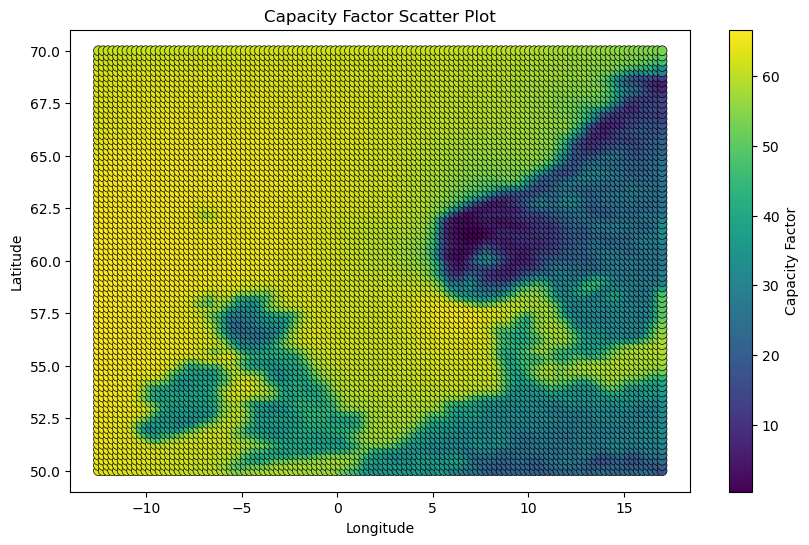

In [6]:
# Assuming coords is a 3D array with shape (num_groups, num_coords, 2)
num_groups, num_coords, _ = coords.shape

num_groups = 81
# Define latitude and longitude values
latitudes = np.linspace(50, 70, num_groups)
longitudes = np.linspace(-12.5, 17, num_coords)

# Create a meshgrid of latitudes and longitudes
latitudes_mesh, longitudes_mesh = np.meshgrid(latitudes, longitudes)

# Initialize cap_fac_store with the correct shape
cap_fac_store = np.zeros((num_coords, num_groups))

for i in range(num_coords):
    current_longitude = longitudes[i]

    for j in range(num_groups):

        current_latitude = latitudes[j]

        ds_cpf = ds['power'].sel(latitude=current_latitude, longitude=current_longitude, method='nearest').mean(dim='time').values
        cap_factor = loss_factor * ds_cpf / 80
        print(f'Coords: ({current_latitude}, {current_longitude}) Capacity factor = {np.round(cap_factor, decimals=2)}')
        cap_fac_store[i, j] = cap_factor

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(longitudes_mesh.flatten(), latitudes_mesh.flatten(), c=cap_fac_store.flatten(), cmap='viridis', s=50, edgecolor='k', linewidth=0.5)
plt.colorbar(scatter, label='Capacity Factor')
plt.title('Capacity Factor Scatter Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [8]:
# Find the indices of the maximum and minimum values in cap_fac_store
max_index = np.unravel_index(np.argmax(cap_fac_store), cap_fac_store.shape)
min_index = np.unravel_index(np.argmin(cap_fac_store), cap_fac_store.shape)

# Get the maximum and minimum capacity factors and their corresponding coordinates
max_cap_factor = cap_fac_store[max_index]
min_cap_factor = cap_fac_store[min_index]

max_latitude, max_longitude = latitudes[max_index[1]], longitudes[max_index[0]]
min_latitude, min_longitude = latitudes[min_index[1]], longitudes[min_index[0]]

print("Highest Capacity Factor:")
print(f"Coordinate: ({max_latitude}, {max_longitude})")
print(f"Capacity Factor: {max_cap_factor}")

print("\nLowest Capacity Factor:")
print(f"Coordinate: ({min_latitude}, {min_longitude})")
print(f"Capacity Factor: {min_cap_factor}")


Highest Capacity Factor:
Coordinate: (57.5, -12.5)
Capacity Factor: 66.64641174316407

Lowest Capacity Factor:
Coordinate: (61.25, 7.331932773109244)
Capacity Factor: 0.3966247701644897


In [7]:

# Assuming coords is a 3D array with shape (num_groups, num_coords, 2)
num_groups, num_coords, _ = coords.shape

num_groups = 81
# Define latitude and longitude values
latitudes = np.linspace(50, 70, num_groups)
longitudes = np.linspace(-12.5, 17, num_coords)

# Create a meshgrid of latitudes and longitudes
latitudes_mesh, longitudes_mesh = np.meshgrid(latitudes, longitudes)

# Initialize cap_fac_store with the correct shape
cap_fac_store = np.zeros((num_coords, num_groups))

for i in range(num_coords):
    current_longitude = longitudes[i]

    for j in range(num_groups):

        current_latitude = latitudes[j]

        ds_cpf = ds['power'].sel(latitude=current_latitude, longitude=current_longitude, method='nearest').mean(dim='time').values
        cap_factor = loss_factor * ds_cpf / 80
        print(f'Coords: ({current_latitude}, {current_longitude}) Capacity factor = {np.round(cap_factor, decimals=2)}')
        cap_fac_store[i, j] = cap_factor




Coords: (50.0, -12.5) Capacity factor = 63.91
Coords: (50.25, -12.5) Capacity factor = 64.03
Coords: (50.5, -12.5) Capacity factor = 64.26
Coords: (50.75, -12.5) Capacity factor = 64.42
Coords: (51.0, -12.5) Capacity factor = 64.54
Coords: (51.25, -12.5) Capacity factor = 64.79
Coords: (51.5, -12.5) Capacity factor = 64.93
Coords: (51.75, -12.5) Capacity factor = 65.09
Coords: (52.0, -12.5) Capacity factor = 65.23
Coords: (52.25, -12.5) Capacity factor = 65.35
Coords: (52.5, -12.5) Capacity factor = 65.5
Coords: (52.75, -12.5) Capacity factor = 65.58
Coords: (53.0, -12.5) Capacity factor = 65.67
Coords: (53.25, -12.5) Capacity factor = 65.73
Coords: (53.5, -12.5) Capacity factor = 65.79
Coords: (53.75, -12.5) Capacity factor = 65.88
Coords: (54.0, -12.5) Capacity factor = 65.87
Coords: (54.25, -12.5) Capacity factor = 65.94
Coords: (54.5, -12.5) Capacity factor = 65.99
Coords: (54.75, -12.5) Capacity factor = 66.04
Coords: (55.0, -12.5) Capacity factor = 66.11
Coords: (55.25, -12.5) Ca

Coords: (69.75, -12.252100840336134) Capacity factor = 61.19
Coords: (70.0, -12.252100840336134) Capacity factor = 60.69
Coords: (50.0, -12.004201680672269) Capacity factor = 63.69
Coords: (50.25, -12.004201680672269) Capacity factor = 63.9
Coords: (50.5, -12.004201680672269) Capacity factor = 64.11
Coords: (50.75, -12.004201680672269) Capacity factor = 64.17
Coords: (51.0, -12.004201680672269) Capacity factor = 64.45
Coords: (51.25, -12.004201680672269) Capacity factor = 64.54
Coords: (51.5, -12.004201680672269) Capacity factor = 64.58
Coords: (51.75, -12.004201680672269) Capacity factor = 64.77
Coords: (52.0, -12.004201680672269) Capacity factor = 64.95
Coords: (52.25, -12.004201680672269) Capacity factor = 65.1
Coords: (52.5, -12.004201680672269) Capacity factor = 65.21
Coords: (52.75, -12.004201680672269) Capacity factor = 65.26
Coords: (53.0, -12.004201680672269) Capacity factor = 65.39
Coords: (53.25, -12.004201680672269) Capacity factor = 65.5
Coords: (53.5, -12.004201680672269)

Coords: (64.75, -11.756302521008404) Capacity factor = 65.29
Coords: (65.0, -11.756302521008404) Capacity factor = 65.05
Coords: (65.25, -11.756302521008404) Capacity factor = 64.89
Coords: (65.5, -11.756302521008404) Capacity factor = 64.61
Coords: (65.75, -11.756302521008404) Capacity factor = 64.24
Coords: (66.0, -11.756302521008404) Capacity factor = 63.88
Coords: (66.25, -11.756302521008404) Capacity factor = 63.56
Coords: (66.5, -11.756302521008404) Capacity factor = 63.37
Coords: (66.75, -11.756302521008404) Capacity factor = 63.37
Coords: (67.0, -11.756302521008404) Capacity factor = 63.23
Coords: (67.25, -11.756302521008404) Capacity factor = 63.21
Coords: (67.5, -11.756302521008404) Capacity factor = 63.14
Coords: (67.75, -11.756302521008404) Capacity factor = 63.1
Coords: (68.0, -11.756302521008404) Capacity factor = 62.98
Coords: (68.25, -11.756302521008404) Capacity factor = 62.92
Coords: (68.5, -11.756302521008404) Capacity factor = 62.83
Coords: (68.75, -11.7563025210084

Coords: (60.0, -11.260504201680671) Capacity factor = 66.1
Coords: (60.25, -11.260504201680671) Capacity factor = 66.09
Coords: (60.5, -11.260504201680671) Capacity factor = 66.11
Coords: (60.75, -11.260504201680671) Capacity factor = 66.08
Coords: (61.0, -11.260504201680671) Capacity factor = 66.13
Coords: (61.25, -11.260504201680671) Capacity factor = 66.18
Coords: (61.5, -11.260504201680671) Capacity factor = 66.17
Coords: (61.75, -11.260504201680671) Capacity factor = 66.16
Coords: (62.0, -11.260504201680671) Capacity factor = 66.14
Coords: (62.25, -11.260504201680671) Capacity factor = 66.0
Coords: (62.5, -11.260504201680671) Capacity factor = 65.98
Coords: (62.75, -11.260504201680671) Capacity factor = 65.91
Coords: (63.0, -11.260504201680671) Capacity factor = 65.79
Coords: (63.25, -11.260504201680671) Capacity factor = 65.73
Coords: (63.5, -11.260504201680671) Capacity factor = 65.71
Coords: (63.75, -11.260504201680671) Capacity factor = 65.77
Coords: (64.0, -11.260504201680671

Coords: (54.75, -10.764705882352942) Capacity factor = 65.34
Coords: (55.0, -10.764705882352942) Capacity factor = 65.52
Coords: (55.25, -10.764705882352942) Capacity factor = 65.57
Coords: (55.5, -10.764705882352942) Capacity factor = 65.61
Coords: (55.75, -10.764705882352942) Capacity factor = 65.57
Coords: (56.0, -10.764705882352942) Capacity factor = 65.63
Coords: (56.25, -10.764705882352942) Capacity factor = 65.62
Coords: (56.5, -10.764705882352942) Capacity factor = 65.63
Coords: (56.75, -10.764705882352942) Capacity factor = 65.71
Coords: (57.0, -10.764705882352942) Capacity factor = 65.75
Coords: (57.25, -10.764705882352942) Capacity factor = 65.77
Coords: (57.5, -10.764705882352942) Capacity factor = 65.77
Coords: (57.75, -10.764705882352942) Capacity factor = 65.84
Coords: (58.0, -10.764705882352942) Capacity factor = 65.86
Coords: (58.25, -10.764705882352942) Capacity factor = 65.88
Coords: (58.5, -10.764705882352942) Capacity factor = 65.92
Coords: (58.75, -10.764705882352

Coords: (69.75, -10.516806722689076) Capacity factor = 61.51
Coords: (70.0, -10.516806722689076) Capacity factor = 60.98
Coords: (50.0, -10.26890756302521) Capacity factor = 62.75
Coords: (50.25, -10.26890756302521) Capacity factor = 62.96
Coords: (50.5, -10.26890756302521) Capacity factor = 63.15
Coords: (50.75, -10.26890756302521) Capacity factor = 63.35
Coords: (51.0, -10.26890756302521) Capacity factor = 63.4
Coords: (51.25, -10.26890756302521) Capacity factor = 62.92
Coords: (51.5, -10.26890756302521) Capacity factor = 61.42
Coords: (51.75, -10.26890756302521) Capacity factor = 53.92
Coords: (52.0, -10.26890756302521) Capacity factor = 48.04
Coords: (52.25, -10.26890756302521) Capacity factor = 50.0
Coords: (52.5, -10.26890756302521) Capacity factor = 58.65
Coords: (52.75, -10.26890756302521) Capacity factor = 62.99
Coords: (53.0, -10.26890756302521) Capacity factor = 63.41
Coords: (53.25, -10.26890756302521) Capacity factor = 62.41
Coords: (53.5, -10.26890756302521) Capacity fact

Coords: (64.75, -10.021008403361344) Capacity factor = 65.55
Coords: (65.0, -10.021008403361344) Capacity factor = 65.43
Coords: (65.25, -10.021008403361344) Capacity factor = 65.28
Coords: (65.5, -10.021008403361344) Capacity factor = 65.13
Coords: (65.75, -10.021008403361344) Capacity factor = 64.94
Coords: (66.0, -10.021008403361344) Capacity factor = 64.72
Coords: (66.25, -10.021008403361344) Capacity factor = 64.56
Coords: (66.5, -10.021008403361344) Capacity factor = 64.46
Coords: (66.75, -10.021008403361344) Capacity factor = 64.42
Coords: (67.0, -10.021008403361344) Capacity factor = 64.24
Coords: (67.25, -10.021008403361344) Capacity factor = 63.99
Coords: (67.5, -10.021008403361344) Capacity factor = 63.85
Coords: (67.75, -10.021008403361344) Capacity factor = 63.73
Coords: (68.0, -10.021008403361344) Capacity factor = 63.51
Coords: (68.25, -10.021008403361344) Capacity factor = 63.33
Coords: (68.5, -10.021008403361344) Capacity factor = 63.21
Coords: (68.75, -10.021008403361

Coords: (59.75, -9.525210084033613) Capacity factor = 65.82
Coords: (60.0, -9.525210084033613) Capacity factor = 65.81
Coords: (60.25, -9.525210084033613) Capacity factor = 65.76
Coords: (60.5, -9.525210084033613) Capacity factor = 65.81
Coords: (60.75, -9.525210084033613) Capacity factor = 65.78
Coords: (61.0, -9.525210084033613) Capacity factor = 65.89
Coords: (61.25, -9.525210084033613) Capacity factor = 65.91
Coords: (61.5, -9.525210084033613) Capacity factor = 65.87
Coords: (61.75, -9.525210084033613) Capacity factor = 65.82
Coords: (62.0, -9.525210084033613) Capacity factor = 65.73
Coords: (62.25, -9.525210084033613) Capacity factor = 65.69
Coords: (62.5, -9.525210084033613) Capacity factor = 65.62
Coords: (62.75, -9.525210084033613) Capacity factor = 65.6
Coords: (63.0, -9.525210084033613) Capacity factor = 65.63
Coords: (63.25, -9.525210084033613) Capacity factor = 65.68
Coords: (63.5, -9.525210084033613) Capacity factor = 65.58
Coords: (63.75, -9.525210084033613) Capacity fact

Coords: (55.0, -9.029411764705882) Capacity factor = 63.88
Coords: (55.25, -9.029411764705882) Capacity factor = 64.42
Coords: (55.5, -9.029411764705882) Capacity factor = 64.8
Coords: (55.75, -9.029411764705882) Capacity factor = 65.0
Coords: (56.0, -9.029411764705882) Capacity factor = 64.85
Coords: (56.25, -9.029411764705882) Capacity factor = 64.92
Coords: (56.5, -9.029411764705882) Capacity factor = 64.97
Coords: (56.75, -9.029411764705882) Capacity factor = 64.88
Coords: (57.0, -9.029411764705882) Capacity factor = 64.86
Coords: (57.25, -9.029411764705882) Capacity factor = 64.8
Coords: (57.5, -9.029411764705882) Capacity factor = 64.87
Coords: (57.75, -9.029411764705882) Capacity factor = 64.94
Coords: (58.0, -9.029411764705882) Capacity factor = 65.15
Coords: (58.25, -9.029411764705882) Capacity factor = 65.28
Coords: (58.5, -9.029411764705882) Capacity factor = 65.45
Coords: (58.75, -9.029411764705882) Capacity factor = 65.51
Coords: (59.0, -9.029411764705882) Capacity factor 

Coords: (69.75, -8.781512605042018) Capacity factor = 61.57
Coords: (70.0, -8.781512605042018) Capacity factor = 61.14
Coords: (50.0, -8.533613445378151) Capacity factor = 61.49
Coords: (50.25, -8.533613445378151) Capacity factor = 61.74
Coords: (50.5, -8.533613445378151) Capacity factor = 61.95
Coords: (50.75, -8.533613445378151) Capacity factor = 62.09
Coords: (51.0, -8.533613445378151) Capacity factor = 61.86
Coords: (51.25, -8.533613445378151) Capacity factor = 61.42
Coords: (51.5, -8.533613445378151) Capacity factor = 56.72
Coords: (51.75, -8.533613445378151) Capacity factor = 46.81
Coords: (52.0, -8.533613445378151) Capacity factor = 37.61
Coords: (52.25, -8.533613445378151) Capacity factor = 35.07
Coords: (52.5, -8.533613445378151) Capacity factor = 35.09
Coords: (52.75, -8.533613445378151) Capacity factor = 35.65
Coords: (53.0, -8.533613445378151) Capacity factor = 36.73
Coords: (53.25, -8.533613445378151) Capacity factor = 38.13
Coords: (53.5, -8.533613445378151) Capacity fact

Coords: (65.0, -8.285714285714285) Capacity factor = 65.32
Coords: (65.25, -8.285714285714285) Capacity factor = 65.23
Coords: (65.5, -8.285714285714285) Capacity factor = 65.12
Coords: (65.75, -8.285714285714285) Capacity factor = 65.0
Coords: (66.0, -8.285714285714285) Capacity factor = 64.81
Coords: (66.25, -8.285714285714285) Capacity factor = 64.72
Coords: (66.5, -8.285714285714285) Capacity factor = 64.62
Coords: (66.75, -8.285714285714285) Capacity factor = 64.5
Coords: (67.0, -8.285714285714285) Capacity factor = 64.34
Coords: (67.25, -8.285714285714285) Capacity factor = 64.21
Coords: (67.5, -8.285714285714285) Capacity factor = 64.07
Coords: (67.75, -8.285714285714285) Capacity factor = 63.89
Coords: (68.0, -8.285714285714285) Capacity factor = 63.64
Coords: (68.25, -8.285714285714285) Capacity factor = 63.49
Coords: (68.5, -8.285714285714285) Capacity factor = 63.31
Coords: (68.75, -8.285714285714285) Capacity factor = 63.14
Coords: (69.0, -8.285714285714285) Capacity factor

Coords: (59.5, -7.7899159663865545) Capacity factor = 65.33
Coords: (59.75, -7.7899159663865545) Capacity factor = 65.34
Coords: (60.0, -7.7899159663865545) Capacity factor = 65.31
Coords: (60.25, -7.7899159663865545) Capacity factor = 65.29
Coords: (60.5, -7.7899159663865545) Capacity factor = 65.3
Coords: (60.75, -7.7899159663865545) Capacity factor = 65.35
Coords: (61.0, -7.7899159663865545) Capacity factor = 65.29
Coords: (61.25, -7.7899159663865545) Capacity factor = 65.25
Coords: (61.5, -7.7899159663865545) Capacity factor = 65.11
Coords: (61.75, -7.7899159663865545) Capacity factor = 64.86
Coords: (62.0, -7.7899159663865545) Capacity factor = 64.81
Coords: (62.25, -7.7899159663865545) Capacity factor = 65.06
Coords: (62.5, -7.7899159663865545) Capacity factor = 65.07
Coords: (62.75, -7.7899159663865545) Capacity factor = 65.1
Coords: (63.0, -7.7899159663865545) Capacity factor = 65.39
Coords: (63.25, -7.7899159663865545) Capacity factor = 65.36
Coords: (63.5, -7.7899159663865545

Coords: (54.5, -7.294117647058823) Capacity factor = 37.71
Coords: (54.75, -7.294117647058823) Capacity factor = 39.4
Coords: (55.0, -7.294117647058823) Capacity factor = 42.57
Coords: (55.25, -7.294117647058823) Capacity factor = 53.9
Coords: (55.5, -7.294117647058823) Capacity factor = 61.55
Coords: (55.75, -7.294117647058823) Capacity factor = 63.75
Coords: (56.0, -7.294117647058823) Capacity factor = 63.73
Coords: (56.25, -7.294117647058823) Capacity factor = 63.64
Coords: (56.5, -7.294117647058823) Capacity factor = 63.53
Coords: (56.75, -7.294117647058823) Capacity factor = 63.52
Coords: (57.0, -7.294117647058823) Capacity factor = 63.46
Coords: (57.25, -7.294117647058823) Capacity factor = 62.86
Coords: (57.5, -7.294117647058823) Capacity factor = 62.38
Coords: (57.75, -7.294117647058823) Capacity factor = 61.73
Coords: (58.0, -7.294117647058823) Capacity factor = 58.32
Coords: (58.25, -7.294117647058823) Capacity factor = 60.62
Coords: (58.5, -7.294117647058823) Capacity factor

Coords: (69.75, -7.046218487394958) Capacity factor = 61.79
Coords: (70.0, -7.046218487394958) Capacity factor = 61.4
Coords: (50.0, -6.798319327731092) Capacity factor = 60.29
Coords: (50.25, -6.798319327731092) Capacity factor = 60.48
Coords: (50.5, -6.798319327731092) Capacity factor = 60.83
Coords: (50.75, -6.798319327731092) Capacity factor = 61.26
Coords: (51.0, -6.798319327731092) Capacity factor = 61.32
Coords: (51.25, -6.798319327731092) Capacity factor = 61.82
Coords: (51.5, -6.798319327731092) Capacity factor = 61.75
Coords: (51.75, -6.798319327731092) Capacity factor = 61.26
Coords: (52.0, -6.798319327731092) Capacity factor = 58.89
Coords: (52.25, -6.798319327731092) Capacity factor = 51.02
Coords: (52.5, -6.798319327731092) Capacity factor = 39.05
Coords: (52.75, -6.798319327731092) Capacity factor = 34.42
Coords: (53.0, -6.798319327731092) Capacity factor = 37.06
Coords: (53.25, -6.798319327731092) Capacity factor = 37.3
Coords: (53.5, -6.798319327731092) Capacity factor

Coords: (65.0, -6.550420168067227) Capacity factor = 65.25
Coords: (65.25, -6.550420168067227) Capacity factor = 65.1
Coords: (65.5, -6.550420168067227) Capacity factor = 64.97
Coords: (65.75, -6.550420168067227) Capacity factor = 64.85
Coords: (66.0, -6.550420168067227) Capacity factor = 64.73
Coords: (66.25, -6.550420168067227) Capacity factor = 64.62
Coords: (66.5, -6.550420168067227) Capacity factor = 64.48
Coords: (66.75, -6.550420168067227) Capacity factor = 64.41
Coords: (67.0, -6.550420168067227) Capacity factor = 64.23
Coords: (67.25, -6.550420168067227) Capacity factor = 64.09
Coords: (67.5, -6.550420168067227) Capacity factor = 63.94
Coords: (67.75, -6.550420168067227) Capacity factor = 63.83
Coords: (68.0, -6.550420168067227) Capacity factor = 63.66
Coords: (68.25, -6.550420168067227) Capacity factor = 63.47
Coords: (68.5, -6.550420168067227) Capacity factor = 63.29
Coords: (68.75, -6.550420168067227) Capacity factor = 63.02
Coords: (69.0, -6.550420168067227) Capacity facto

Coords: (60.25, -6.054621848739496) Capacity factor = 64.81
Coords: (60.5, -6.054621848739496) Capacity factor = 64.72
Coords: (60.75, -6.054621848739496) Capacity factor = 64.67
Coords: (61.0, -6.054621848739496) Capacity factor = 64.65
Coords: (61.25, -6.054621848739496) Capacity factor = 64.59
Coords: (61.5, -6.054621848739496) Capacity factor = 64.6
Coords: (61.75, -6.054621848739496) Capacity factor = 64.59
Coords: (62.0, -6.054621848739496) Capacity factor = 63.85
Coords: (62.25, -6.054621848739496) Capacity factor = 62.35
Coords: (62.5, -6.054621848739496) Capacity factor = 63.65
Coords: (62.75, -6.054621848739496) Capacity factor = 64.73
Coords: (63.0, -6.054621848739496) Capacity factor = 64.91
Coords: (63.25, -6.054621848739496) Capacity factor = 65.07
Coords: (63.5, -6.054621848739496) Capacity factor = 65.1
Coords: (63.75, -6.054621848739496) Capacity factor = 65.11
Coords: (64.0, -6.054621848739496) Capacity factor = 65.18
Coords: (64.25, -6.054621848739496) Capacity facto

Coords: (54.75, -5.5588235294117645) Capacity factor = 54.55
Coords: (55.0, -5.5588235294117645) Capacity factor = 58.36
Coords: (55.25, -5.5588235294117645) Capacity factor = 60.57
Coords: (55.5, -5.5588235294117645) Capacity factor = 62.5
Coords: (55.75, -5.5588235294117645) Capacity factor = 58.6
Coords: (56.0, -5.5588235294117645) Capacity factor = 50.88
Coords: (56.25, -5.5588235294117645) Capacity factor = 45.92
Coords: (56.5, -5.5588235294117645) Capacity factor = 36.32
Coords: (56.75, -5.5588235294117645) Capacity factor = 29.48
Coords: (57.0, -5.5588235294117645) Capacity factor = 28.96
Coords: (57.25, -5.5588235294117645) Capacity factor = 29.62
Coords: (57.5, -5.5588235294117645) Capacity factor = 32.65
Coords: (57.75, -5.5588235294117645) Capacity factor = 40.46
Coords: (58.0, -5.5588235294117645) Capacity factor = 51.68
Coords: (58.25, -5.5588235294117645) Capacity factor = 57.06
Coords: (58.5, -5.5588235294117645) Capacity factor = 61.52
Coords: (58.75, -5.558823529411764

Coords: (69.75, -5.310924369747899) Capacity factor = 62.11
Coords: (70.0, -5.310924369747899) Capacity factor = 61.74
Coords: (50.0, -5.063025210084033) Capacity factor = 54.14
Coords: (50.25, -5.063025210084033) Capacity factor = 48.76
Coords: (50.5, -5.063025210084033) Capacity factor = 49.97
Coords: (50.75, -5.063025210084033) Capacity factor = 55.15
Coords: (51.0, -5.063025210084033) Capacity factor = 58.65
Coords: (51.25, -5.063025210084033) Capacity factor = 59.6
Coords: (51.5, -5.063025210084033) Capacity factor = 57.65
Coords: (51.75, -5.063025210084033) Capacity factor = 53.24
Coords: (52.0, -5.063025210084033) Capacity factor = 53.49
Coords: (52.25, -5.063025210084033) Capacity factor = 56.55
Coords: (52.5, -5.063025210084033) Capacity factor = 59.24
Coords: (52.75, -5.063025210084033) Capacity factor = 59.28
Coords: (53.0, -5.063025210084033) Capacity factor = 58.99
Coords: (53.25, -5.063025210084033) Capacity factor = 58.2
Coords: (53.5, -5.063025210084033) Capacity factor

Coords: (65.75, -4.815126050420168) Capacity factor = 64.61
Coords: (66.0, -4.815126050420168) Capacity factor = 64.49
Coords: (66.25, -4.815126050420168) Capacity factor = 64.38
Coords: (66.5, -4.815126050420168) Capacity factor = 64.24
Coords: (66.75, -4.815126050420168) Capacity factor = 64.17
Coords: (67.0, -4.815126050420168) Capacity factor = 64.01
Coords: (67.25, -4.815126050420168) Capacity factor = 63.92
Coords: (67.5, -4.815126050420168) Capacity factor = 63.8
Coords: (67.75, -4.815126050420168) Capacity factor = 63.65
Coords: (68.0, -4.815126050420168) Capacity factor = 63.46
Coords: (68.25, -4.815126050420168) Capacity factor = 63.26
Coords: (68.5, -4.815126050420168) Capacity factor = 63.11
Coords: (68.75, -4.815126050420168) Capacity factor = 62.92
Coords: (69.0, -4.815126050420168) Capacity factor = 62.75
Coords: (69.25, -4.815126050420168) Capacity factor = 62.56
Coords: (69.5, -4.815126050420168) Capacity factor = 62.33
Coords: (69.75, -4.815126050420168) Capacity fact

Coords: (61.0, -4.319327731092436) Capacity factor = 64.51
Coords: (61.25, -4.319327731092436) Capacity factor = 64.47
Coords: (61.5, -4.319327731092436) Capacity factor = 64.46
Coords: (61.75, -4.319327731092436) Capacity factor = 64.67
Coords: (62.0, -4.319327731092436) Capacity factor = 64.71
Coords: (62.25, -4.319327731092436) Capacity factor = 64.85
Coords: (62.5, -4.319327731092436) Capacity factor = 64.86
Coords: (62.75, -4.319327731092436) Capacity factor = 64.89
Coords: (63.0, -4.319327731092436) Capacity factor = 64.88
Coords: (63.25, -4.319327731092436) Capacity factor = 64.94
Coords: (63.5, -4.319327731092436) Capacity factor = 64.98
Coords: (63.75, -4.319327731092436) Capacity factor = 64.98
Coords: (64.0, -4.319327731092436) Capacity factor = 65.06
Coords: (64.25, -4.319327731092436) Capacity factor = 65.01
Coords: (64.5, -4.319327731092436) Capacity factor = 65.02
Coords: (64.75, -4.319327731092436) Capacity factor = 64.97
Coords: (65.0, -4.319327731092436) Capacity fact

Coords: (56.5, -3.8235294117647065) Capacity factor = 25.53
Coords: (56.75, -3.8235294117647065) Capacity factor = 28.2
Coords: (57.0, -3.8235294117647065) Capacity factor = 32.2
Coords: (57.25, -3.8235294117647065) Capacity factor = 33.41
Coords: (57.5, -3.8235294117647065) Capacity factor = 35.83
Coords: (57.75, -3.8235294117647065) Capacity factor = 41.99
Coords: (58.0, -3.8235294117647065) Capacity factor = 43.1
Coords: (58.25, -3.8235294117647065) Capacity factor = 44.26
Coords: (58.5, -3.8235294117647065) Capacity factor = 53.49
Coords: (58.75, -3.8235294117647065) Capacity factor = 59.36
Coords: (59.0, -3.8235294117647065) Capacity factor = 62.69
Coords: (59.25, -3.8235294117647065) Capacity factor = 63.97
Coords: (59.5, -3.8235294117647065) Capacity factor = 64.15
Coords: (59.75, -3.8235294117647065) Capacity factor = 64.53
Coords: (60.0, -3.8235294117647065) Capacity factor = 64.56
Coords: (60.25, -3.8235294117647065) Capacity factor = 64.54
Coords: (60.5, -3.8235294117647065)

Coords: (52.0, -3.3277310924369736) Capacity factor = 35.35
Coords: (52.25, -3.3277310924369736) Capacity factor = 36.81
Coords: (52.5, -3.3277310924369736) Capacity factor = 37.82
Coords: (52.75, -3.3277310924369736) Capacity factor = 36.39
Coords: (53.0, -3.3277310924369736) Capacity factor = 34.3
Coords: (53.25, -3.3277310924369736) Capacity factor = 37.24
Coords: (53.5, -3.3277310924369736) Capacity factor = 49.97
Coords: (53.75, -3.3277310924369736) Capacity factor = 54.04
Coords: (54.0, -3.3277310924369736) Capacity factor = 52.46
Coords: (54.25, -3.3277310924369736) Capacity factor = 44.89
Coords: (54.5, -3.3277310924369736) Capacity factor = 38.72
Coords: (54.75, -3.3277310924369736) Capacity factor = 36.57
Coords: (55.0, -3.3277310924369736) Capacity factor = 35.34
Coords: (55.25, -3.3277310924369736) Capacity factor = 35.32
Coords: (55.5, -3.3277310924369736) Capacity factor = 40.7
Coords: (55.75, -3.3277310924369736) Capacity factor = 41.03
Coords: (56.0, -3.3277310924369736

Coords: (67.0, -3.079831932773109) Capacity factor = 63.71
Coords: (67.25, -3.079831932773109) Capacity factor = 63.56
Coords: (67.5, -3.079831932773109) Capacity factor = 63.47
Coords: (67.75, -3.079831932773109) Capacity factor = 63.37
Coords: (68.0, -3.079831932773109) Capacity factor = 63.22
Coords: (68.25, -3.079831932773109) Capacity factor = 63.09
Coords: (68.5, -3.079831932773109) Capacity factor = 62.99
Coords: (68.75, -3.079831932773109) Capacity factor = 62.89
Coords: (69.0, -3.079831932773109) Capacity factor = 62.79
Coords: (69.25, -3.079831932773109) Capacity factor = 62.64
Coords: (69.5, -3.079831932773109) Capacity factor = 62.46
Coords: (69.75, -3.079831932773109) Capacity factor = 62.27
Coords: (70.0, -3.079831932773109) Capacity factor = 61.97
Coords: (50.0, -2.8319327731092443) Capacity factor = 58.56
Coords: (50.25, -2.8319327731092443) Capacity factor = 57.28
Coords: (50.5, -2.8319327731092443) Capacity factor = 52.32
Coords: (50.75, -2.8319327731092443) Capacity 

Coords: (62.5, -2.584033613445378) Capacity factor = 64.35
Coords: (62.75, -2.584033613445378) Capacity factor = 64.33
Coords: (63.0, -2.584033613445378) Capacity factor = 64.42
Coords: (63.25, -2.584033613445378) Capacity factor = 64.41
Coords: (63.5, -2.584033613445378) Capacity factor = 64.43
Coords: (63.75, -2.584033613445378) Capacity factor = 64.46
Coords: (64.0, -2.584033613445378) Capacity factor = 64.49
Coords: (64.25, -2.584033613445378) Capacity factor = 64.57
Coords: (64.5, -2.584033613445378) Capacity factor = 64.5
Coords: (64.75, -2.584033613445378) Capacity factor = 64.43
Coords: (65.0, -2.584033613445378) Capacity factor = 64.33
Coords: (65.25, -2.584033613445378) Capacity factor = 64.26
Coords: (65.5, -2.584033613445378) Capacity factor = 64.17
Coords: (65.75, -2.584033613445378) Capacity factor = 64.06
Coords: (66.0, -2.584033613445378) Capacity factor = 63.97
Coords: (66.25, -2.584033613445378) Capacity factor = 63.9
Coords: (66.5, -2.584033613445378) Capacity factor

Coords: (58.0, -2.0882352941176467) Capacity factor = 61.76
Coords: (58.25, -2.0882352941176467) Capacity factor = 62.47
Coords: (58.5, -2.0882352941176467) Capacity factor = 62.9
Coords: (58.75, -2.0882352941176467) Capacity factor = 63.15
Coords: (59.0, -2.0882352941176467) Capacity factor = 63.32
Coords: (59.25, -2.0882352941176467) Capacity factor = 63.45
Coords: (59.5, -2.0882352941176467) Capacity factor = 63.46
Coords: (59.75, -2.0882352941176467) Capacity factor = 63.66
Coords: (60.0, -2.0882352941176467) Capacity factor = 63.72
Coords: (60.25, -2.0882352941176467) Capacity factor = 63.86
Coords: (60.5, -2.0882352941176467) Capacity factor = 63.94
Coords: (60.75, -2.0882352941176467) Capacity factor = 63.91
Coords: (61.0, -2.0882352941176467) Capacity factor = 63.81
Coords: (61.25, -2.0882352941176467) Capacity factor = 63.82
Coords: (61.5, -2.0882352941176467) Capacity factor = 63.82
Coords: (61.75, -2.0882352941176467) Capacity factor = 63.86
Coords: (62.0, -2.088235294117646

Coords: (53.5, -1.5924369747899156) Capacity factor = 41.82
Coords: (53.75, -1.5924369747899156) Capacity factor = 40.51
Coords: (54.0, -1.5924369747899156) Capacity factor = 40.08
Coords: (54.25, -1.5924369747899156) Capacity factor = 39.98
Coords: (54.5, -1.5924369747899156) Capacity factor = 40.25
Coords: (54.75, -1.5924369747899156) Capacity factor = 42.67
Coords: (55.0, -1.5924369747899156) Capacity factor = 44.57
Coords: (55.25, -1.5924369747899156) Capacity factor = 49.67
Coords: (55.5, -1.5924369747899156) Capacity factor = 52.59
Coords: (55.75, -1.5924369747899156) Capacity factor = 57.32
Coords: (56.0, -1.5924369747899156) Capacity factor = 60.23
Coords: (56.25, -1.5924369747899156) Capacity factor = 61.93
Coords: (56.5, -1.5924369747899156) Capacity factor = 62.26
Coords: (56.75, -1.5924369747899156) Capacity factor = 62.0
Coords: (57.0, -1.5924369747899156) Capacity factor = 61.3
Coords: (57.25, -1.5924369747899156) Capacity factor = 60.28
Coords: (57.5, -1.5924369747899156

Coords: (69.25, -1.3445378151260492) Capacity factor = 62.47
Coords: (69.5, -1.3445378151260492) Capacity factor = 62.29
Coords: (69.75, -1.3445378151260492) Capacity factor = 62.13
Coords: (70.0, -1.3445378151260492) Capacity factor = 61.89
Coords: (50.0, -1.0966386554621845) Capacity factor = 57.26
Coords: (50.25, -1.0966386554621845) Capacity factor = 57.33
Coords: (50.5, -1.0966386554621845) Capacity factor = 55.86
Coords: (50.75, -1.0966386554621845) Capacity factor = 48.79
Coords: (51.0, -1.0966386554621845) Capacity factor = 39.79
Coords: (51.25, -1.0966386554621845) Capacity factor = 38.7
Coords: (51.5, -1.0966386554621845) Capacity factor = 38.41
Coords: (51.75, -1.0966386554621845) Capacity factor = 39.07
Coords: (52.0, -1.0966386554621845) Capacity factor = 40.82
Coords: (52.25, -1.0966386554621845) Capacity factor = 42.5
Coords: (52.5, -1.0966386554621845) Capacity factor = 43.66
Coords: (52.75, -1.0966386554621845) Capacity factor = 44.01
Coords: (53.0, -1.0966386554621845

Coords: (64.75, -0.8487394957983199) Capacity factor = 63.67
Coords: (65.0, -0.8487394957983199) Capacity factor = 63.64
Coords: (65.25, -0.8487394957983199) Capacity factor = 63.61
Coords: (65.5, -0.8487394957983199) Capacity factor = 63.57
Coords: (65.75, -0.8487394957983199) Capacity factor = 63.51
Coords: (66.0, -0.8487394957983199) Capacity factor = 63.46
Coords: (66.25, -0.8487394957983199) Capacity factor = 63.39
Coords: (66.5, -0.8487394957983199) Capacity factor = 63.35
Coords: (66.75, -0.8487394957983199) Capacity factor = 63.34
Coords: (67.0, -0.8487394957983199) Capacity factor = 63.23
Coords: (67.25, -0.8487394957983199) Capacity factor = 63.11
Coords: (67.5, -0.8487394957983199) Capacity factor = 62.96
Coords: (67.75, -0.8487394957983199) Capacity factor = 62.88
Coords: (68.0, -0.8487394957983199) Capacity factor = 62.83
Coords: (68.25, -0.8487394957983199) Capacity factor = 62.79
Coords: (68.5, -0.8487394957983199) Capacity factor = 62.77
Coords: (68.75, -0.8487394957983

Coords: (60.25, -0.352941176470587) Capacity factor = 62.36
Coords: (60.5, -0.352941176470587) Capacity factor = 62.3
Coords: (60.75, -0.352941176470587) Capacity factor = 62.24
Coords: (61.0, -0.352941176470587) Capacity factor = 62.28
Coords: (61.25, -0.352941176470587) Capacity factor = 62.27
Coords: (61.5, -0.352941176470587) Capacity factor = 62.34
Coords: (61.75, -0.352941176470587) Capacity factor = 62.46
Coords: (62.0, -0.352941176470587) Capacity factor = 62.61
Coords: (62.25, -0.352941176470587) Capacity factor = 62.79
Coords: (62.5, -0.352941176470587) Capacity factor = 62.93
Coords: (62.75, -0.352941176470587) Capacity factor = 63.08
Coords: (63.0, -0.352941176470587) Capacity factor = 63.2
Coords: (63.25, -0.352941176470587) Capacity factor = 63.28
Coords: (63.5, -0.352941176470587) Capacity factor = 63.36
Coords: (63.75, -0.352941176470587) Capacity factor = 63.32
Coords: (64.0, -0.352941176470587) Capacity factor = 63.32
Coords: (64.25, -0.352941176470587) Capacity facto

Coords: (54.0, 0.14285714285714235) Capacity factor = 57.53
Coords: (54.25, 0.14285714285714235) Capacity factor = 58.62
Coords: (54.5, 0.14285714285714235) Capacity factor = 59.13
Coords: (54.75, 0.14285714285714235) Capacity factor = 59.72
Coords: (55.0, 0.14285714285714235) Capacity factor = 60.61
Coords: (55.25, 0.14285714285714235) Capacity factor = 60.97
Coords: (55.5, 0.14285714285714235) Capacity factor = 61.24
Coords: (55.75, 0.14285714285714235) Capacity factor = 61.57
Coords: (56.0, 0.14285714285714235) Capacity factor = 61.75
Coords: (56.25, 0.14285714285714235) Capacity factor = 62.05
Coords: (56.5, 0.14285714285714235) Capacity factor = 62.04
Coords: (56.75, 0.14285714285714235) Capacity factor = 61.93
Coords: (57.0, 0.14285714285714235) Capacity factor = 61.85
Coords: (57.25, 0.14285714285714235) Capacity factor = 61.8
Coords: (57.5, 0.14285714285714235) Capacity factor = 61.82
Coords: (57.75, 0.14285714285714235) Capacity factor = 61.94
Coords: (58.0, 0.1428571428571423

Coords: (69.25, 0.3907563025210088) Capacity factor = 62.05
Coords: (69.5, 0.3907563025210088) Capacity factor = 61.93
Coords: (69.75, 0.3907563025210088) Capacity factor = 61.78
Coords: (70.0, 0.3907563025210088) Capacity factor = 61.64
Coords: (50.0, 0.6386554621848752) Capacity factor = 48.9
Coords: (50.25, 0.6386554621848752) Capacity factor = 54.31
Coords: (50.5, 0.6386554621848752) Capacity factor = 56.6
Coords: (50.75, 0.6386554621848752) Capacity factor = 54.36
Coords: (51.0, 0.6386554621848752) Capacity factor = 44.61
Coords: (51.25, 0.6386554621848752) Capacity factor = 40.13
Coords: (51.5, 0.6386554621848752) Capacity factor = 44.01
Coords: (51.75, 0.6386554621848752) Capacity factor = 44.35
Coords: (52.0, 0.6386554621848752) Capacity factor = 43.29
Coords: (52.25, 0.6386554621848752) Capacity factor = 40.63
Coords: (52.5, 0.6386554621848752) Capacity factor = 40.0
Coords: (52.75, 0.6386554621848752) Capacity factor = 45.79
Coords: (53.0, 0.6386554621848752) Capacity factor 

Coords: (64.5, 0.8865546218487399) Capacity factor = 62.66
Coords: (64.75, 0.8865546218487399) Capacity factor = 62.66
Coords: (65.0, 0.8865546218487399) Capacity factor = 62.69
Coords: (65.25, 0.8865546218487399) Capacity factor = 62.75
Coords: (65.5, 0.8865546218487399) Capacity factor = 62.78
Coords: (65.75, 0.8865546218487399) Capacity factor = 62.81
Coords: (66.0, 0.8865546218487399) Capacity factor = 62.79
Coords: (66.25, 0.8865546218487399) Capacity factor = 62.8
Coords: (66.5, 0.8865546218487399) Capacity factor = 62.79
Coords: (66.75, 0.8865546218487399) Capacity factor = 62.75
Coords: (67.0, 0.8865546218487399) Capacity factor = 62.62
Coords: (67.25, 0.8865546218487399) Capacity factor = 62.53
Coords: (67.5, 0.8865546218487399) Capacity factor = 62.46
Coords: (67.75, 0.8865546218487399) Capacity factor = 62.38
Coords: (68.0, 0.8865546218487399) Capacity factor = 62.32
Coords: (68.25, 0.8865546218487399) Capacity factor = 62.3
Coords: (68.5, 0.8865546218487399) Capacity factor

Coords: (60.0, 1.382352941176471) Capacity factor = 60.71
Coords: (60.25, 1.382352941176471) Capacity factor = 60.58
Coords: (60.5, 1.382352941176471) Capacity factor = 60.4
Coords: (60.75, 1.382352941176471) Capacity factor = 60.28
Coords: (61.0, 1.382352941176471) Capacity factor = 60.24
Coords: (61.25, 1.382352941176471) Capacity factor = 60.25
Coords: (61.5, 1.382352941176471) Capacity factor = 60.45
Coords: (61.75, 1.382352941176471) Capacity factor = 60.66
Coords: (62.0, 1.382352941176471) Capacity factor = 61.03
Coords: (62.25, 1.382352941176471) Capacity factor = 61.36
Coords: (62.5, 1.382352941176471) Capacity factor = 61.65
Coords: (62.75, 1.382352941176471) Capacity factor = 62.0
Coords: (63.0, 1.382352941176471) Capacity factor = 62.14
Coords: (63.25, 1.382352941176471) Capacity factor = 62.27
Coords: (63.5, 1.382352941176471) Capacity factor = 62.33
Coords: (63.75, 1.382352941176471) Capacity factor = 62.35
Coords: (64.0, 1.382352941176471) Capacity factor = 62.27
Coords: 

Coords: (54.75, 1.8781512605042021) Capacity factor = 60.62
Coords: (55.0, 1.8781512605042021) Capacity factor = 60.79
Coords: (55.25, 1.8781512605042021) Capacity factor = 60.97
Coords: (55.5, 1.8781512605042021) Capacity factor = 61.21
Coords: (55.75, 1.8781512605042021) Capacity factor = 61.32
Coords: (56.0, 1.8781512605042021) Capacity factor = 61.3
Coords: (56.25, 1.8781512605042021) Capacity factor = 61.16
Coords: (56.5, 1.8781512605042021) Capacity factor = 61.21
Coords: (56.75, 1.8781512605042021) Capacity factor = 61.29
Coords: (57.0, 1.8781512605042021) Capacity factor = 61.34
Coords: (57.25, 1.8781512605042021) Capacity factor = 61.35
Coords: (57.5, 1.8781512605042021) Capacity factor = 61.38
Coords: (57.75, 1.8781512605042021) Capacity factor = 61.56
Coords: (58.0, 1.8781512605042021) Capacity factor = 61.59
Coords: (58.25, 1.8781512605042021) Capacity factor = 61.57
Coords: (58.5, 1.8781512605042021) Capacity factor = 61.44
Coords: (58.75, 1.8781512605042021) Capacity fact

Coords: (50.75, 2.373949579831933) Capacity factor = 37.13
Coords: (51.0, 2.373949579831933) Capacity factor = 42.41
Coords: (51.25, 2.373949579831933) Capacity factor = 53.24
Coords: (51.5, 2.373949579831933) Capacity factor = 56.59
Coords: (51.75, 2.373949579831933) Capacity factor = 57.82
Coords: (52.0, 2.373949579831933) Capacity factor = 58.1
Coords: (52.25, 2.373949579831933) Capacity factor = 58.31
Coords: (52.5, 2.373949579831933) Capacity factor = 58.35
Coords: (52.75, 2.373949579831933) Capacity factor = 58.42
Coords: (53.0, 2.373949579831933) Capacity factor = 58.74
Coords: (53.25, 2.373949579831933) Capacity factor = 59.03
Coords: (53.5, 2.373949579831933) Capacity factor = 59.39
Coords: (53.75, 2.373949579831933) Capacity factor = 59.81
Coords: (54.0, 2.373949579831933) Capacity factor = 60.18
Coords: (54.25, 2.373949579831933) Capacity factor = 60.3
Coords: (54.5, 2.373949579831933) Capacity factor = 60.41
Coords: (54.75, 2.373949579831933) Capacity factor = 60.63
Coords:

Coords: (66.5, 2.6218487394957997) Capacity factor = 61.93
Coords: (66.75, 2.6218487394957997) Capacity factor = 61.98
Coords: (67.0, 2.6218487394957997) Capacity factor = 61.89
Coords: (67.25, 2.6218487394957997) Capacity factor = 61.83
Coords: (67.5, 2.6218487394957997) Capacity factor = 61.85
Coords: (67.75, 2.6218487394957997) Capacity factor = 61.83
Coords: (68.0, 2.6218487394957997) Capacity factor = 61.82
Coords: (68.25, 2.6218487394957997) Capacity factor = 61.78
Coords: (68.5, 2.6218487394957997) Capacity factor = 61.74
Coords: (68.75, 2.6218487394957997) Capacity factor = 61.69
Coords: (69.0, 2.6218487394957997) Capacity factor = 61.65
Coords: (69.25, 2.6218487394957997) Capacity factor = 61.59
Coords: (69.5, 2.6218487394957997) Capacity factor = 61.51
Coords: (69.75, 2.6218487394957997) Capacity factor = 61.42
Coords: (70.0, 2.6218487394957997) Capacity factor = 61.3
Coords: (50.0, 2.8697478991596643) Capacity factor = 34.9
Coords: (50.25, 2.8697478991596643) Capacity factor

Coords: (62.0, 3.117647058823529) Capacity factor = 60.01
Coords: (62.25, 3.117647058823529) Capacity factor = 60.39
Coords: (62.5, 3.117647058823529) Capacity factor = 60.64
Coords: (62.75, 3.117647058823529) Capacity factor = 60.79
Coords: (63.0, 3.117647058823529) Capacity factor = 61.0
Coords: (63.25, 3.117647058823529) Capacity factor = 60.99
Coords: (63.5, 3.117647058823529) Capacity factor = 61.04
Coords: (63.75, 3.117647058823529) Capacity factor = 61.16
Coords: (64.0, 3.117647058823529) Capacity factor = 61.08
Coords: (64.25, 3.117647058823529) Capacity factor = 60.97
Coords: (64.5, 3.117647058823529) Capacity factor = 61.05
Coords: (64.75, 3.117647058823529) Capacity factor = 61.05
Coords: (65.0, 3.117647058823529) Capacity factor = 61.15
Coords: (65.25, 3.117647058823529) Capacity factor = 61.25
Coords: (65.5, 3.117647058823529) Capacity factor = 61.36
Coords: (65.75, 3.117647058823529) Capacity factor = 61.47
Coords: (66.0, 3.117647058823529) Capacity factor = 61.53
Coords:

Coords: (56.75, 3.613445378151262) Capacity factor = 62.2
Coords: (57.0, 3.613445378151262) Capacity factor = 62.38
Coords: (57.25, 3.613445378151262) Capacity factor = 62.49
Coords: (57.5, 3.613445378151262) Capacity factor = 62.72
Coords: (57.75, 3.613445378151262) Capacity factor = 62.7
Coords: (58.0, 3.613445378151262) Capacity factor = 62.53
Coords: (58.25, 3.613445378151262) Capacity factor = 62.15
Coords: (58.5, 3.613445378151262) Capacity factor = 61.7
Coords: (58.75, 3.613445378151262) Capacity factor = 61.16
Coords: (59.0, 3.613445378151262) Capacity factor = 60.53
Coords: (59.25, 3.613445378151262) Capacity factor = 59.85
Coords: (59.5, 3.613445378151262) Capacity factor = 59.14
Coords: (59.75, 3.613445378151262) Capacity factor = 58.57
Coords: (60.0, 3.613445378151262) Capacity factor = 58.02
Coords: (60.25, 3.613445378151262) Capacity factor = 57.5
Coords: (60.5, 3.613445378151262) Capacity factor = 57.32
Coords: (60.75, 3.613445378151262) Capacity factor = 57.35
Coords: (

Coords: (52.25, 4.109243697478991) Capacity factor = 55.04
Coords: (52.5, 4.109243697478991) Capacity factor = 57.56
Coords: (52.75, 4.109243697478991) Capacity factor = 58.37
Coords: (53.0, 4.109243697478991) Capacity factor = 58.81
Coords: (53.25, 4.109243697478991) Capacity factor = 59.21
Coords: (53.5, 4.109243697478991) Capacity factor = 59.7
Coords: (53.75, 4.109243697478991) Capacity factor = 60.08
Coords: (54.0, 4.109243697478991) Capacity factor = 60.39
Coords: (54.25, 4.109243697478991) Capacity factor = 60.73
Coords: (54.5, 4.109243697478991) Capacity factor = 61.02
Coords: (54.75, 4.109243697478991) Capacity factor = 61.26
Coords: (55.0, 4.109243697478991) Capacity factor = 61.49
Coords: (55.25, 4.109243697478991) Capacity factor = 61.71
Coords: (55.5, 4.109243697478991) Capacity factor = 61.97
Coords: (55.75, 4.109243697478991) Capacity factor = 62.06
Coords: (56.0, 4.109243697478991) Capacity factor = 62.22
Coords: (56.25, 4.109243697478991) Capacity factor = 62.34
Coords

Coords: (68.0, 4.357142857142858) Capacity factor = 61.0
Coords: (68.25, 4.357142857142858) Capacity factor = 61.09
Coords: (68.5, 4.357142857142858) Capacity factor = 61.14
Coords: (68.75, 4.357142857142858) Capacity factor = 61.14
Coords: (69.0, 4.357142857142858) Capacity factor = 61.09
Coords: (69.25, 4.357142857142858) Capacity factor = 61.08
Coords: (69.5, 4.357142857142858) Capacity factor = 61.02
Coords: (69.75, 4.357142857142858) Capacity factor = 61.0
Coords: (70.0, 4.357142857142858) Capacity factor = 60.97
Coords: (50.0, 4.605042016806724) Capacity factor = 34.89
Coords: (50.25, 4.605042016806724) Capacity factor = 36.06
Coords: (50.5, 4.605042016806724) Capacity factor = 36.18
Coords: (50.75, 4.605042016806724) Capacity factor = 36.14
Coords: (51.0, 4.605042016806724) Capacity factor = 33.59
Coords: (51.25, 4.605042016806724) Capacity factor = 34.15
Coords: (51.5, 4.605042016806724) Capacity factor = 36.06
Coords: (51.75, 4.605042016806724) Capacity factor = 37.62
Coords: 

Coords: (63.5, 4.852941176470587) Capacity factor = 58.44
Coords: (63.75, 4.852941176470587) Capacity factor = 58.61
Coords: (64.0, 4.852941176470587) Capacity factor = 58.67
Coords: (64.25, 4.852941176470587) Capacity factor = 58.77
Coords: (64.5, 4.852941176470587) Capacity factor = 58.98
Coords: (64.75, 4.852941176470587) Capacity factor = 59.06
Coords: (65.0, 4.852941176470587) Capacity factor = 59.18
Coords: (65.25, 4.852941176470587) Capacity factor = 59.46
Coords: (65.5, 4.852941176470587) Capacity factor = 59.56
Coords: (65.75, 4.852941176470587) Capacity factor = 59.79
Coords: (66.0, 4.852941176470587) Capacity factor = 60.02
Coords: (66.25, 4.852941176470587) Capacity factor = 60.22
Coords: (66.5, 4.852941176470587) Capacity factor = 60.44
Coords: (66.75, 4.852941176470587) Capacity factor = 60.49
Coords: (67.0, 4.852941176470587) Capacity factor = 60.5
Coords: (67.25, 4.852941176470587) Capacity factor = 60.54
Coords: (67.5, 4.852941176470587) Capacity factor = 60.57
Coords:

Coords: (59.0, 5.34873949579832) Capacity factor = 53.16
Coords: (59.25, 5.34873949579832) Capacity factor = 46.7
Coords: (59.5, 5.34873949579832) Capacity factor = 41.11
Coords: (59.75, 5.34873949579832) Capacity factor = 42.45
Coords: (60.0, 5.34873949579832) Capacity factor = 39.52
Coords: (60.25, 5.34873949579832) Capacity factor = 30.4
Coords: (60.5, 5.34873949579832) Capacity factor = 31.03
Coords: (60.75, 5.34873949579832) Capacity factor = 33.17
Coords: (61.0, 5.34873949579832) Capacity factor = 35.92
Coords: (61.25, 5.34873949579832) Capacity factor = 35.41
Coords: (61.5, 5.34873949579832) Capacity factor = 37.6
Coords: (61.75, 5.34873949579832) Capacity factor = 40.11
Coords: (62.0, 5.34873949579832) Capacity factor = 42.24
Coords: (62.25, 5.34873949579832) Capacity factor = 50.75
Coords: (62.5, 5.34873949579832) Capacity factor = 54.64
Coords: (62.75, 5.34873949579832) Capacity factor = 55.4
Coords: (63.0, 5.34873949579832) Capacity factor = 56.81
Coords: (63.25, 5.348739495

Coords: (54.5, 5.844537815126053) Capacity factor = 61.53
Coords: (54.75, 5.844537815126053) Capacity factor = 61.81
Coords: (55.0, 5.844537815126053) Capacity factor = 62.13
Coords: (55.25, 5.844537815126053) Capacity factor = 62.45
Coords: (55.5, 5.844537815126053) Capacity factor = 62.82
Coords: (55.75, 5.844537815126053) Capacity factor = 63.08
Coords: (56.0, 5.844537815126053) Capacity factor = 63.56
Coords: (56.25, 5.844537815126053) Capacity factor = 63.92
Coords: (56.5, 5.844537815126053) Capacity factor = 64.16
Coords: (56.75, 5.844537815126053) Capacity factor = 64.5
Coords: (57.0, 5.844537815126053) Capacity factor = 64.78
Coords: (57.25, 5.844537815126053) Capacity factor = 65.13
Coords: (57.5, 5.844537815126053) Capacity factor = 65.41
Coords: (57.75, 5.844537815126053) Capacity factor = 65.27
Coords: (58.0, 5.844537815126053) Capacity factor = 63.88
Coords: (58.25, 5.844537815126053) Capacity factor = 60.46
Coords: (58.5, 5.844537815126053) Capacity factor = 51.26
Coords:

Coords: (50.0, 6.340336134453782) Capacity factor = 29.74
Coords: (50.25, 6.340336134453782) Capacity factor = 35.14
Coords: (50.5, 6.340336134453782) Capacity factor = 38.59
Coords: (50.75, 6.340336134453782) Capacity factor = 35.51
Coords: (51.0, 6.340336134453782) Capacity factor = 31.89
Coords: (51.25, 6.340336134453782) Capacity factor = 30.69
Coords: (51.5, 6.340336134453782) Capacity factor = 31.06
Coords: (51.75, 6.340336134453782) Capacity factor = 31.85
Coords: (52.0, 6.340336134453782) Capacity factor = 33.76
Coords: (52.25, 6.340336134453782) Capacity factor = 35.43
Coords: (52.5, 6.340336134453782) Capacity factor = 36.19
Coords: (52.75, 6.340336134453782) Capacity factor = 37.62
Coords: (53.0, 6.340336134453782) Capacity factor = 39.66
Coords: (53.25, 6.340336134453782) Capacity factor = 43.83
Coords: (53.5, 6.340336134453782) Capacity factor = 55.59
Coords: (53.75, 6.340336134453782) Capacity factor = 59.57
Coords: (54.0, 6.340336134453782) Capacity factor = 60.73
Coords

Coords: (65.75, 6.5882352941176485) Capacity factor = 58.2
Coords: (66.0, 6.5882352941176485) Capacity factor = 58.56
Coords: (66.25, 6.5882352941176485) Capacity factor = 59.01
Coords: (66.5, 6.5882352941176485) Capacity factor = 59.34
Coords: (66.75, 6.5882352941176485) Capacity factor = 59.56
Coords: (67.0, 6.5882352941176485) Capacity factor = 59.77
Coords: (67.25, 6.5882352941176485) Capacity factor = 59.79
Coords: (67.5, 6.5882352941176485) Capacity factor = 59.82
Coords: (67.75, 6.5882352941176485) Capacity factor = 59.91
Coords: (68.0, 6.5882352941176485) Capacity factor = 60.01
Coords: (68.25, 6.5882352941176485) Capacity factor = 60.14
Coords: (68.5, 6.5882352941176485) Capacity factor = 60.28
Coords: (68.75, 6.5882352941176485) Capacity factor = 60.29
Coords: (69.0, 6.5882352941176485) Capacity factor = 60.35
Coords: (69.25, 6.5882352941176485) Capacity factor = 60.36
Coords: (69.5, 6.5882352941176485) Capacity factor = 60.44
Coords: (69.75, 6.5882352941176485) Capacity fact

Coords: (61.0, 7.084033613445378) Capacity factor = 1.86
Coords: (61.25, 7.084033613445378) Capacity factor = 0.62
Coords: (61.5, 7.084033613445378) Capacity factor = 0.95
Coords: (61.75, 7.084033613445378) Capacity factor = 2.13
Coords: (62.0, 7.084033613445378) Capacity factor = 2.93
Coords: (62.25, 7.084033613445378) Capacity factor = 3.52
Coords: (62.5, 7.084033613445378) Capacity factor = 8.89
Coords: (62.75, 7.084033613445378) Capacity factor = 21.95
Coords: (63.0, 7.084033613445378) Capacity factor = 41.15
Coords: (63.25, 7.084033613445378) Capacity factor = 47.51
Coords: (63.5, 7.084033613445378) Capacity factor = 51.26
Coords: (63.75, 7.084033613445378) Capacity factor = 52.6
Coords: (64.0, 7.084033613445378) Capacity factor = 54.12
Coords: (64.25, 7.084033613445378) Capacity factor = 55.01
Coords: (64.5, 7.084033613445378) Capacity factor = 55.94
Coords: (64.75, 7.084033613445378) Capacity factor = 56.18
Coords: (65.0, 7.084033613445378) Capacity factor = 56.62
Coords: (65.25

Coords: (56.5, 7.579831932773111) Capacity factor = 63.31
Coords: (56.75, 7.579831932773111) Capacity factor = 63.7
Coords: (57.0, 7.579831932773111) Capacity factor = 64.31
Coords: (57.25, 7.579831932773111) Capacity factor = 64.33
Coords: (57.5, 7.579831932773111) Capacity factor = 64.19
Coords: (57.75, 7.579831932773111) Capacity factor = 61.41
Coords: (58.0, 7.579831932773111) Capacity factor = 49.62
Coords: (58.25, 7.579831932773111) Capacity factor = 36.48
Coords: (58.5, 7.579831932773111) Capacity factor = 31.17
Coords: (58.75, 7.579831932773111) Capacity factor = 25.93
Coords: (59.0, 7.579831932773111) Capacity factor = 20.9
Coords: (59.25, 7.579831932773111) Capacity factor = 18.6
Coords: (59.5, 7.579831932773111) Capacity factor = 17.51
Coords: (59.75, 7.579831932773111) Capacity factor = 18.24
Coords: (60.0, 7.579831932773111) Capacity factor = 29.32
Coords: (60.25, 7.579831932773111) Capacity factor = 28.85
Coords: (60.5, 7.579831932773111) Capacity factor = 16.21
Coords: (

Coords: (52.75, 8.07563025210084) Capacity factor = 32.5
Coords: (53.0, 8.07563025210084) Capacity factor = 33.46
Coords: (53.25, 8.07563025210084) Capacity factor = 35.11
Coords: (53.5, 8.07563025210084) Capacity factor = 41.9
Coords: (53.75, 8.07563025210084) Capacity factor = 54.01
Coords: (54.0, 8.07563025210084) Capacity factor = 59.11
Coords: (54.25, 8.07563025210084) Capacity factor = 60.51
Coords: (54.5, 8.07563025210084) Capacity factor = 60.84
Coords: (54.75, 8.07563025210084) Capacity factor = 61.3
Coords: (55.0, 8.07563025210084) Capacity factor = 61.28
Coords: (55.25, 8.07563025210084) Capacity factor = 61.38
Coords: (55.5, 8.07563025210084) Capacity factor = 59.76
Coords: (55.75, 8.07563025210084) Capacity factor = 59.75
Coords: (56.0, 8.07563025210084) Capacity factor = 60.25
Coords: (56.25, 8.07563025210084) Capacity factor = 60.5
Coords: (56.5, 8.07563025210084) Capacity factor = 60.74
Coords: (56.75, 8.07563025210084) Capacity factor = 60.12
Coords: (57.0, 8.075630252

Coords: (50.25, 8.571428571428573) Capacity factor = 20.11
Coords: (50.5, 8.571428571428573) Capacity factor = 21.97
Coords: (50.75, 8.571428571428573) Capacity factor = 24.34
Coords: (51.0, 8.571428571428573) Capacity factor = 27.52
Coords: (51.25, 8.571428571428573) Capacity factor = 31.87
Coords: (51.5, 8.571428571428573) Capacity factor = 33.95
Coords: (51.75, 8.571428571428573) Capacity factor = 32.62
Coords: (52.0, 8.571428571428573) Capacity factor = 31.97
Coords: (52.25, 8.571428571428573) Capacity factor = 31.91
Coords: (52.5, 8.571428571428573) Capacity factor = 31.79
Coords: (52.75, 8.571428571428573) Capacity factor = 32.17
Coords: (53.0, 8.571428571428573) Capacity factor = 33.2
Coords: (53.25, 8.571428571428573) Capacity factor = 33.68
Coords: (53.5, 8.571428571428573) Capacity factor = 39.02
Coords: (53.75, 8.571428571428573) Capacity factor = 49.96
Coords: (54.0, 8.571428571428573) Capacity factor = 55.45
Coords: (54.25, 8.571428571428573) Capacity factor = 57.27
Coords

Coords: (66.5, 8.819327731092436) Capacity factor = 58.02
Coords: (66.75, 8.819327731092436) Capacity factor = 58.28
Coords: (67.0, 8.819327731092436) Capacity factor = 58.53
Coords: (67.25, 8.819327731092436) Capacity factor = 58.66
Coords: (67.5, 8.819327731092436) Capacity factor = 58.64
Coords: (67.75, 8.819327731092436) Capacity factor = 58.75
Coords: (68.0, 8.819327731092436) Capacity factor = 58.82
Coords: (68.25, 8.819327731092436) Capacity factor = 58.89
Coords: (68.5, 8.819327731092436) Capacity factor = 59.03
Coords: (68.75, 8.819327731092436) Capacity factor = 59.12
Coords: (69.0, 8.819327731092436) Capacity factor = 59.27
Coords: (69.25, 8.819327731092436) Capacity factor = 59.38
Coords: (69.5, 8.819327731092436) Capacity factor = 59.45
Coords: (69.75, 8.819327731092436) Capacity factor = 59.56
Coords: (70.0, 8.819327731092436) Capacity factor = 59.6
Coords: (50.0, 9.067226890756302) Capacity factor = 22.11
Coords: (50.25, 9.067226890756302) Capacity factor = 21.29
Coords:

Coords: (61.75, 9.315126050420169) Capacity factor = 4.82
Coords: (62.0, 9.315126050420169) Capacity factor = 7.23
Coords: (62.25, 9.315126050420169) Capacity factor = 9.87
Coords: (62.5, 9.315126050420169) Capacity factor = 7.81
Coords: (62.75, 9.315126050420169) Capacity factor = 11.01
Coords: (63.0, 9.315126050420169) Capacity factor = 12.21
Coords: (63.25, 9.315126050420169) Capacity factor = 18.34
Coords: (63.5, 9.315126050420169) Capacity factor = 31.18
Coords: (63.75, 9.315126050420169) Capacity factor = 46.82
Coords: (64.0, 9.315126050420169) Capacity factor = 51.98
Coords: (64.25, 9.315126050420169) Capacity factor = 53.52
Coords: (64.5, 9.315126050420169) Capacity factor = 54.59
Coords: (64.75, 9.315126050420169) Capacity factor = 55.32
Coords: (65.0, 9.315126050420169) Capacity factor = 56.12
Coords: (65.25, 9.315126050420169) Capacity factor = 56.42
Coords: (65.5, 9.315126050420169) Capacity factor = 56.76
Coords: (65.75, 9.315126050420169) Capacity factor = 57.08
Coords: (

Coords: (57.25, 9.810924369747902) Capacity factor = 44.96
Coords: (57.5, 9.810924369747902) Capacity factor = 51.66
Coords: (57.75, 9.810924369747902) Capacity factor = 58.45
Coords: (58.0, 9.810924369747902) Capacity factor = 58.88
Coords: (58.25, 9.810924369747902) Capacity factor = 56.64
Coords: (58.5, 9.810924369747902) Capacity factor = 54.2
Coords: (58.75, 9.810924369747902) Capacity factor = 47.0
Coords: (59.0, 9.810924369747902) Capacity factor = 36.4
Coords: (59.25, 9.810924369747902) Capacity factor = 21.47
Coords: (59.5, 9.810924369747902) Capacity factor = 14.04
Coords: (59.75, 9.810924369747902) Capacity factor = 9.94
Coords: (60.0, 9.810924369747902) Capacity factor = 6.7
Coords: (60.25, 9.810924369747902) Capacity factor = 6.33
Coords: (60.5, 9.810924369747902) Capacity factor = 6.43
Coords: (60.75, 9.810924369747902) Capacity factor = 8.06
Coords: (61.0, 9.810924369747902) Capacity factor = 10.04
Coords: (61.25, 9.810924369747902) Capacity factor = 10.49
Coords: (61.5,

Coords: (52.5, 10.306722689075631) Capacity factor = 30.7
Coords: (52.75, 10.306722689075631) Capacity factor = 31.88
Coords: (53.0, 10.306722689075631) Capacity factor = 33.38
Coords: (53.25, 10.306722689075631) Capacity factor = 33.47
Coords: (53.5, 10.306722689075631) Capacity factor = 33.62
Coords: (53.75, 10.306722689075631) Capacity factor = 34.55
Coords: (54.0, 10.306722689075631) Capacity factor = 35.84
Coords: (54.25, 10.306722689075631) Capacity factor = 40.63
Coords: (54.5, 10.306722689075631) Capacity factor = 47.32
Coords: (54.75, 10.306722689075631) Capacity factor = 51.85
Coords: (55.0, 10.306722689075631) Capacity factor = 50.89
Coords: (55.25, 10.306722689075631) Capacity factor = 45.64
Coords: (55.5, 10.306722689075631) Capacity factor = 46.19
Coords: (55.75, 10.306722689075631) Capacity factor = 52.6
Coords: (56.0, 10.306722689075631) Capacity factor = 48.97
Coords: (56.25, 10.306722689075631) Capacity factor = 44.29
Coords: (56.5, 10.306722689075631) Capacity factor

Coords: (68.25, 10.554621848739497) Capacity factor = 57.33
Coords: (68.5, 10.554621848739497) Capacity factor = 57.57
Coords: (68.75, 10.554621848739497) Capacity factor = 57.74
Coords: (69.0, 10.554621848739497) Capacity factor = 58.0
Coords: (69.25, 10.554621848739497) Capacity factor = 58.12
Coords: (69.5, 10.554621848739497) Capacity factor = 58.34
Coords: (69.75, 10.554621848739497) Capacity factor = 58.44
Coords: (70.0, 10.554621848739497) Capacity factor = 58.6
Coords: (50.0, 10.80252100840336) Capacity factor = 20.19
Coords: (50.25, 10.80252100840336) Capacity factor = 20.22
Coords: (50.5, 10.80252100840336) Capacity factor = 22.52
Coords: (50.75, 10.80252100840336) Capacity factor = 25.04
Coords: (51.0, 10.80252100840336) Capacity factor = 26.88
Coords: (51.25, 10.80252100840336) Capacity factor = 27.24
Coords: (51.5, 10.80252100840336) Capacity factor = 27.71
Coords: (51.75, 10.80252100840336) Capacity factor = 27.92
Coords: (52.0, 10.80252100840336) Capacity factor = 29.23


Coords: (63.75, 11.050420168067227) Capacity factor = 17.53
Coords: (64.0, 11.050420168067227) Capacity factor = 19.76
Coords: (64.25, 11.050420168067227) Capacity factor = 28.54
Coords: (64.5, 11.050420168067227) Capacity factor = 39.61
Coords: (64.75, 11.050420168067227) Capacity factor = 49.8
Coords: (65.0, 11.050420168067227) Capacity factor = 52.57
Coords: (65.25, 11.050420168067227) Capacity factor = 54.8
Coords: (65.5, 11.050420168067227) Capacity factor = 54.8
Coords: (65.75, 11.050420168067227) Capacity factor = 55.58
Coords: (66.0, 11.050420168067227) Capacity factor = 55.49
Coords: (66.25, 11.050420168067227) Capacity factor = 55.78
Coords: (66.5, 11.050420168067227) Capacity factor = 56.37
Coords: (66.75, 11.050420168067227) Capacity factor = 56.34
Coords: (67.0, 11.050420168067227) Capacity factor = 56.17
Coords: (67.25, 11.050420168067227) Capacity factor = 55.94
Coords: (67.5, 11.050420168067227) Capacity factor = 56.1
Coords: (67.75, 11.050420168067227) Capacity factor 

Coords: (59.25, 11.54621848739496) Capacity factor = 28.0
Coords: (59.5, 11.54621848739496) Capacity factor = 26.44
Coords: (59.75, 11.54621848739496) Capacity factor = 25.49
Coords: (60.0, 11.54621848739496) Capacity factor = 22.7
Coords: (60.25, 11.54621848739496) Capacity factor = 18.48
Coords: (60.5, 11.54621848739496) Capacity factor = 16.16
Coords: (60.75, 11.54621848739496) Capacity factor = 13.89
Coords: (61.0, 11.54621848739496) Capacity factor = 13.84
Coords: (61.25, 11.54621848739496) Capacity factor = 13.38
Coords: (61.5, 11.54621848739496) Capacity factor = 13.88
Coords: (61.75, 11.54621848739496) Capacity factor = 14.22
Coords: (62.0, 11.54621848739496) Capacity factor = 17.31
Coords: (62.25, 11.54621848739496) Capacity factor = 20.07
Coords: (62.5, 11.54621848739496) Capacity factor = 22.34
Coords: (62.75, 11.54621848739496) Capacity factor = 26.45
Coords: (63.0, 11.54621848739496) Capacity factor = 25.57
Coords: (63.25, 11.54621848739496) Capacity factor = 24.14
Coords:

Coords: (54.5, 12.042016806722689) Capacity factor = 54.0
Coords: (54.75, 12.042016806722689) Capacity factor = 55.23
Coords: (55.0, 12.042016806722689) Capacity factor = 54.56
Coords: (55.25, 12.042016806722689) Capacity factor = 48.29
Coords: (55.5, 12.042016806722689) Capacity factor = 43.13
Coords: (55.75, 12.042016806722689) Capacity factor = 44.31
Coords: (56.0, 12.042016806722689) Capacity factor = 51.07
Coords: (56.25, 12.042016806722689) Capacity factor = 55.98
Coords: (56.5, 12.042016806722689) Capacity factor = 56.26
Coords: (56.75, 12.042016806722689) Capacity factor = 54.8
Coords: (57.0, 12.042016806722689) Capacity factor = 52.75
Coords: (57.25, 12.042016806722689) Capacity factor = 47.38
Coords: (57.5, 12.042016806722689) Capacity factor = 38.14
Coords: (57.75, 12.042016806722689) Capacity factor = 34.88
Coords: (58.0, 12.042016806722689) Capacity factor = 35.1
Coords: (58.25, 12.042016806722689) Capacity factor = 31.45
Coords: (58.5, 12.042016806722689) Capacity factor 

Coords: (50.0, 12.537815126050422) Capacity factor = 23.9
Coords: (50.25, 12.537815126050422) Capacity factor = 24.68
Coords: (50.5, 12.537815126050422) Capacity factor = 26.88
Coords: (50.75, 12.537815126050422) Capacity factor = 27.42
Coords: (51.0, 12.537815126050422) Capacity factor = 26.31
Coords: (51.25, 12.537815126050422) Capacity factor = 27.62
Coords: (51.5, 12.537815126050422) Capacity factor = 27.34
Coords: (51.75, 12.537815126050422) Capacity factor = 27.56
Coords: (52.0, 12.537815126050422) Capacity factor = 28.41
Coords: (52.25, 12.537815126050422) Capacity factor = 28.73
Coords: (52.5, 12.537815126050422) Capacity factor = 28.34
Coords: (52.75, 12.537815126050422) Capacity factor = 28.41
Coords: (53.0, 12.537815126050422) Capacity factor = 30.09
Coords: (53.25, 12.537815126050422) Capacity factor = 33.62
Coords: (53.5, 12.537815126050422) Capacity factor = 35.31
Coords: (53.75, 12.537815126050422) Capacity factor = 34.68
Coords: (54.0, 12.537815126050422) Capacity facto

Coords: (65.75, 12.785714285714285) Capacity factor = 17.88
Coords: (66.0, 12.785714285714285) Capacity factor = 26.92
Coords: (66.25, 12.785714285714285) Capacity factor = 39.11
Coords: (66.5, 12.785714285714285) Capacity factor = 44.72
Coords: (66.75, 12.785714285714285) Capacity factor = 49.34
Coords: (67.0, 12.785714285714285) Capacity factor = 49.25
Coords: (67.25, 12.785714285714285) Capacity factor = 49.4
Coords: (67.5, 12.785714285714285) Capacity factor = 50.94
Coords: (67.75, 12.785714285714285) Capacity factor = 53.12
Coords: (68.0, 12.785714285714285) Capacity factor = 54.43
Coords: (68.25, 12.785714285714285) Capacity factor = 54.97
Coords: (68.5, 12.785714285714285) Capacity factor = 55.06
Coords: (68.75, 12.785714285714285) Capacity factor = 55.79
Coords: (69.0, 12.785714285714285) Capacity factor = 56.25
Coords: (69.25, 12.785714285714285) Capacity factor = 56.35
Coords: (69.5, 12.785714285714285) Capacity factor = 56.37
Coords: (69.75, 12.785714285714285) Capacity fact

Coords: (61.25, 13.281512605042018) Capacity factor = 21.55
Coords: (61.5, 13.281512605042018) Capacity factor = 21.49
Coords: (61.75, 13.281512605042018) Capacity factor = 22.97
Coords: (62.0, 13.281512605042018) Capacity factor = 24.35
Coords: (62.25, 13.281512605042018) Capacity factor = 23.49
Coords: (62.5, 13.281512605042018) Capacity factor = 21.54
Coords: (62.75, 13.281512605042018) Capacity factor = 23.01
Coords: (63.0, 13.281512605042018) Capacity factor = 23.58
Coords: (63.25, 13.281512605042018) Capacity factor = 21.9
Coords: (63.5, 13.281512605042018) Capacity factor = 22.79
Coords: (63.75, 13.281512605042018) Capacity factor = 26.27
Coords: (64.0, 13.281512605042018) Capacity factor = 29.67
Coords: (64.25, 13.281512605042018) Capacity factor = 28.83
Coords: (64.5, 13.281512605042018) Capacity factor = 25.95
Coords: (64.75, 13.281512605042018) Capacity factor = 23.35
Coords: (65.0, 13.281512605042018) Capacity factor = 18.57
Coords: (65.25, 13.281512605042018) Capacity fact

Coords: (56.75, 13.77731092436975) Capacity factor = 33.66
Coords: (57.0, 13.77731092436975) Capacity factor = 31.7
Coords: (57.25, 13.77731092436975) Capacity factor = 30.68
Coords: (57.5, 13.77731092436975) Capacity factor = 30.31
Coords: (57.75, 13.77731092436975) Capacity factor = 31.8
Coords: (58.0, 13.77731092436975) Capacity factor = 31.5
Coords: (58.25, 13.77731092436975) Capacity factor = 30.94
Coords: (58.5, 13.77731092436975) Capacity factor = 29.94
Coords: (58.75, 13.77731092436975) Capacity factor = 38.76
Coords: (59.0, 13.77731092436975) Capacity factor = 43.91
Coords: (59.25, 13.77731092436975) Capacity factor = 39.0
Coords: (59.5, 13.77731092436975) Capacity factor = 28.65
Coords: (59.75, 13.77731092436975) Capacity factor = 24.64
Coords: (60.0, 13.77731092436975) Capacity factor = 24.95
Coords: (60.25, 13.77731092436975) Capacity factor = 25.07
Coords: (60.5, 13.77731092436975) Capacity factor = 25.88
Coords: (60.75, 13.77731092436975) Capacity factor = 25.27
Coords: (

Coords: (52.25, 14.27310924369748) Capacity factor = 29.46
Coords: (52.5, 14.27310924369748) Capacity factor = 30.98
Coords: (52.75, 14.27310924369748) Capacity factor = 30.93
Coords: (53.0, 14.27310924369748) Capacity factor = 31.57
Coords: (53.25, 14.27310924369748) Capacity factor = 33.61
Coords: (53.5, 14.27310924369748) Capacity factor = 35.5
Coords: (53.75, 14.27310924369748) Capacity factor = 40.88
Coords: (54.0, 14.27310924369748) Capacity factor = 49.7
Coords: (54.25, 14.27310924369748) Capacity factor = 55.39
Coords: (54.5, 14.27310924369748) Capacity factor = 57.11
Coords: (54.75, 14.27310924369748) Capacity factor = 58.08
Coords: (55.0, 14.27310924369748) Capacity factor = 58.27
Coords: (55.25, 14.27310924369748) Capacity factor = 56.96
Coords: (55.5, 14.27310924369748) Capacity factor = 52.43
Coords: (55.75, 14.27310924369748) Capacity factor = 48.12
Coords: (56.0, 14.27310924369748) Capacity factor = 41.52
Coords: (56.25, 14.27310924369748) Capacity factor = 33.41
Coords:

Coords: (68.0, 14.521008403361346) Capacity factor = 44.4
Coords: (68.25, 14.521008403361346) Capacity factor = 45.08
Coords: (68.5, 14.521008403361346) Capacity factor = 41.41
Coords: (68.75, 14.521008403361346) Capacity factor = 40.94
Coords: (69.0, 14.521008403361346) Capacity factor = 49.69
Coords: (69.25, 14.521008403361346) Capacity factor = 53.78
Coords: (69.5, 14.521008403361346) Capacity factor = 54.23
Coords: (69.75, 14.521008403361346) Capacity factor = 55.11
Coords: (70.0, 14.521008403361346) Capacity factor = 55.36
Coords: (50.0, 14.76890756302521) Capacity factor = 22.31
Coords: (50.25, 14.76890756302521) Capacity factor = 22.09
Coords: (50.5, 14.76890756302521) Capacity factor = 21.02
Coords: (50.75, 14.76890756302521) Capacity factor = 23.0
Coords: (51.0, 14.76890756302521) Capacity factor = 29.26
Coords: (51.25, 14.76890756302521) Capacity factor = 29.89
Coords: (51.5, 14.76890756302521) Capacity factor = 29.85
Coords: (51.75, 14.76890756302521) Capacity factor = 29.25

Coords: (62.75, 15.016806722689076) Capacity factor = 25.71
Coords: (63.0, 15.016806722689076) Capacity factor = 26.45
Coords: (63.25, 15.016806722689076) Capacity factor = 26.33
Coords: (63.5, 15.016806722689076) Capacity factor = 25.27
Coords: (63.75, 15.016806722689076) Capacity factor = 24.61
Coords: (64.0, 15.016806722689076) Capacity factor = 25.23
Coords: (64.25, 15.016806722689076) Capacity factor = 25.29
Coords: (64.5, 15.016806722689076) Capacity factor = 24.08
Coords: (64.75, 15.016806722689076) Capacity factor = 22.13
Coords: (65.0, 15.016806722689076) Capacity factor = 22.88
Coords: (65.25, 15.016806722689076) Capacity factor = 21.92
Coords: (65.5, 15.016806722689076) Capacity factor = 19.23
Coords: (65.75, 15.016806722689076) Capacity factor = 15.54
Coords: (66.0, 15.016806722689076) Capacity factor = 15.02
Coords: (66.25, 15.016806722689076) Capacity factor = 14.5
Coords: (66.5, 15.016806722689076) Capacity factor = 10.48
Coords: (66.75, 15.016806722689076) Capacity fact

Coords: (57.25, 15.512605042016808) Capacity factor = 31.69
Coords: (57.5, 15.512605042016808) Capacity factor = 31.21
Coords: (57.75, 15.512605042016808) Capacity factor = 30.72
Coords: (58.0, 15.512605042016808) Capacity factor = 31.08
Coords: (58.25, 15.512605042016808) Capacity factor = 29.87
Coords: (58.5, 15.512605042016808) Capacity factor = 29.67
Coords: (58.75, 15.512605042016808) Capacity factor = 29.35
Coords: (59.0, 15.512605042016808) Capacity factor = 28.89
Coords: (59.25, 15.512605042016808) Capacity factor = 28.04
Coords: (59.5, 15.512605042016808) Capacity factor = 26.74
Coords: (59.75, 15.512605042016808) Capacity factor = 26.84
Coords: (60.0, 15.512605042016808) Capacity factor = 27.62
Coords: (60.25, 15.512605042016808) Capacity factor = 26.5
Coords: (60.5, 15.512605042016808) Capacity factor = 24.3
Coords: (60.75, 15.512605042016808) Capacity factor = 24.69
Coords: (61.0, 15.512605042016808) Capacity factor = 25.1
Coords: (61.25, 15.512605042016808) Capacity factor

Coords: (52.75, 16.008403361344538) Capacity factor = 29.34
Coords: (53.0, 16.008403361344538) Capacity factor = 30.03
Coords: (53.25, 16.008403361344538) Capacity factor = 32.09
Coords: (53.5, 16.008403361344538) Capacity factor = 35.08
Coords: (53.75, 16.008403361344538) Capacity factor = 34.91
Coords: (54.0, 16.008403361344538) Capacity factor = 36.15
Coords: (54.25, 16.008403361344538) Capacity factor = 44.69
Coords: (54.5, 16.008403361344538) Capacity factor = 52.21
Coords: (54.75, 16.008403361344538) Capacity factor = 56.68
Coords: (55.0, 16.008403361344538) Capacity factor = 57.62
Coords: (55.25, 16.008403361344538) Capacity factor = 58.33
Coords: (55.5, 16.008403361344538) Capacity factor = 58.65
Coords: (55.75, 16.008403361344538) Capacity factor = 58.74
Coords: (56.0, 16.008403361344538) Capacity factor = 55.92
Coords: (56.25, 16.008403361344538) Capacity factor = 46.95
Coords: (56.5, 16.008403361344538) Capacity factor = 34.29
Coords: (56.75, 16.008403361344538) Capacity fac

Coords: (68.5, 16.256302521008404) Capacity factor = 12.74
Coords: (68.75, 16.256302521008404) Capacity factor = 16.49
Coords: (69.0, 16.256302521008404) Capacity factor = 33.54
Coords: (69.25, 16.256302521008404) Capacity factor = 43.05
Coords: (69.5, 16.256302521008404) Capacity factor = 50.31
Coords: (69.75, 16.256302521008404) Capacity factor = 53.15
Coords: (70.0, 16.256302521008404) Capacity factor = 53.97
Coords: (50.0, 16.50420168067227) Capacity factor = 22.24
Coords: (50.25, 16.50420168067227) Capacity factor = 19.86
Coords: (50.5, 16.50420168067227) Capacity factor = 22.6
Coords: (50.75, 16.50420168067227) Capacity factor = 25.82
Coords: (51.0, 16.50420168067227) Capacity factor = 29.72
Coords: (51.25, 16.50420168067227) Capacity factor = 29.33
Coords: (51.5, 16.50420168067227) Capacity factor = 31.08
Coords: (51.75, 16.50420168067227) Capacity factor = 32.12
Coords: (52.0, 16.50420168067227) Capacity factor = 31.44
Coords: (52.25, 16.50420168067227) Capacity factor = 30.7
C

Coords: (65.0, 16.752100840336134) Capacity factor = 22.19
Coords: (65.25, 16.752100840336134) Capacity factor = 21.71
Coords: (65.5, 16.752100840336134) Capacity factor = 21.25
Coords: (65.75, 16.752100840336134) Capacity factor = 20.77
Coords: (66.0, 16.752100840336134) Capacity factor = 19.66
Coords: (66.25, 16.752100840336134) Capacity factor = 18.27
Coords: (66.5, 16.752100840336134) Capacity factor = 18.15
Coords: (66.75, 16.752100840336134) Capacity factor = 15.69
Coords: (67.0, 16.752100840336134) Capacity factor = 14.72
Coords: (67.25, 16.752100840336134) Capacity factor = 15.84
Coords: (67.5, 16.752100840336134) Capacity factor = 15.18
Coords: (67.75, 16.752100840336134) Capacity factor = 13.38
Coords: (68.0, 16.752100840336134) Capacity factor = 11.63
Coords: (68.25, 16.752100840336134) Capacity factor = 9.42
Coords: (68.5, 16.752100840336134) Capacity factor = 7.88
Coords: (68.75, 16.752100840336134) Capacity factor = 13.8
Coords: (69.0, 16.752100840336134) Capacity factor 

/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


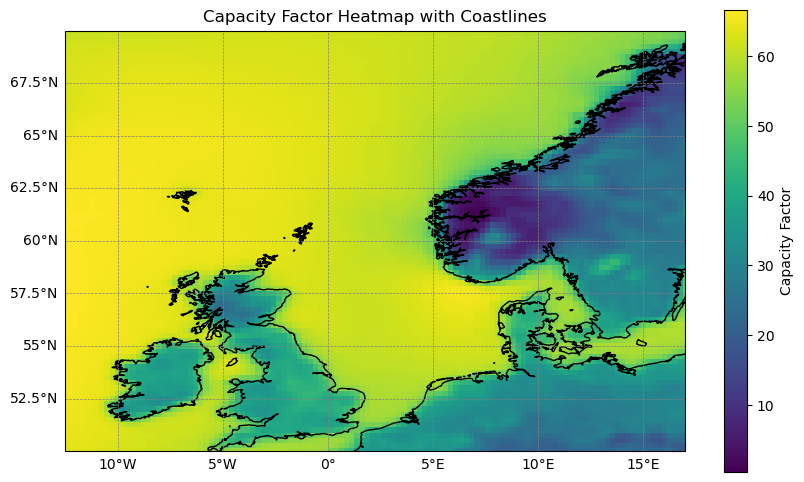

In [9]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Assuming you have longitudes_mesh, latitudes_mesh, and cap_fac_store defined

# Create a regular heatmap with coastal outlines
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use pcolormesh for the heatmap
heatmap = plt.pcolormesh(longitudes_mesh, latitudes_mesh, cap_fac_store, cmap='viridis', transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Set the extent to cut off at specific latitude and longitude values
ax.set_xlim([-12.5, 17])
ax.set_ylim([50, 70])

plt.colorbar(heatmap, label='Capacity Factor')
plt.title('Capacity Factor Heatmap with Coastlines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


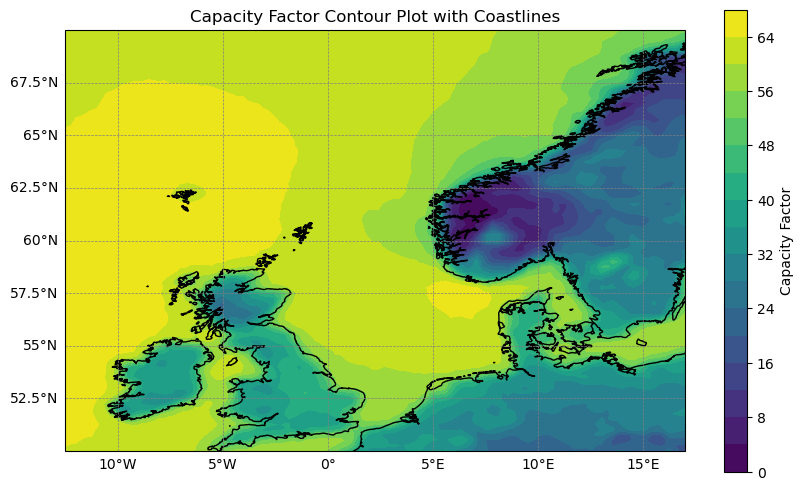

In [10]:


# Create a contour plot with coastlines
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
contour = plt.contourf(longitudes_mesh, latitudes_mesh, cap_fac_store, cmap='viridis', levels=20, transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Set the extent to cut off at specific latitude and longitude values
ax.set_xlim([-12.5, 17])
ax.set_ylim([50, 70])

plt.colorbar(contour, label='Capacity Factor')
plt.title('Capacity Factor Contour Plot with Coastlines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


